---
title: "Fine-Tining Kodis"
author: "Michelle Gelman"
date: "04/30/2025"
format: 
  html:
    code-fold: true
    execute:
      eval: false
      echo: True
      cache: True
jupyter: python3
---


# Initial Performance Impressions
- I spent a lot of time looking at CRAFT under the hood this week to see possible modifications. This initial "exploratory" fine-tuning notebook ended up necessitating using cloud compute(used [deepnote](www.deepnote.com)) for fine-tuning (GP4 -L4 $1.56/hr) to get some initial results, as each run for fine-tuning one model with training size (1264) was taking 40 min to train on my machine. To really improve results, I would look into setting up full end-to-end with python scripts to manage experiment runs better. I did a couple this week (1-3 for each model variant) in this notebook, and there is still randomness that is not reproducible across experiment runs. There is a lot fo room to modify the "model_config" for CRAFT and perhaps do dynamic adjustments to the learning rate for each batch, as I had issues with overfitting, but this notebook is not generalizble to test at this level.
- What does "doing better" mean to know if we should continue? Pivot to analysis with self-report scores?
    - **It is pretty ineffecient to continue workin in jupyter notebook for fine-tuning as this is no way a robust training pipeline, but I wanted to touch base to see if the above would make sense to continue trying**

- The few downsampling training runs had high accuracy variablitiy (27% to 80%)
- There are some clear upward patterns in the prediciton scores broken out by success/impasse's emerging
- downsampling does affect the accuracy quite a bit
- AUC/PR curves look promising. I also chose the best threshold and plotted metric comparisons as well as the Confusion Matrix across each variant.

# Experiment set ups:
- Use wiki-pretrained model params as base
- model default forecast threshold is .54.
- Use fine-tuned wiki model as base comparison for all fine-tuning results
- fine-tune model varitions with:
    - conversations with all utterances (ground)
    - conversations with no last utterance (no_last)
    - conversations with no last no submit agreement box (no last no submit) (note that there are left over "chains of agree/disgree as response after agreement submission, which I did leave)

Model Improvement Considerations:
- In craft, changed the Binary cross entropy loss to weighted  Binary cross entropy loss in train.py based on class imbalance. Created Cost Sensitive CRAFT model
- Downsampled from training set to get even impassee/success training split
- default



# Development Notes
- According to craft paper, only context prior to derailment comment is used in training. 
    - "Note that by construction, the last comment of each conversation is the one marked as derailment, and that our earlier code was therefore set up to not look at the last comment, meaning that all forecasts we obtained are forecasts made prior to derailment. This simplifies the computation of forecast accuracy as we now do not need to explicitly consider when a forecast was made." 

    - [Reproducible code for CMV data](https://colab.research.google.com/drive/1GvICZN0VwZQSWw3pJaEVY-EQGoO-L5lH#scrollTo=FYxW_AuWszqX)
    - [Reproducible code for WIKI data (fine-tuning + inference)](https://github.com/jpwchang/CRAFT/blob/main/fine_tuning_demo.ipynb)
    - [New Forecaster Framework says to follow training on last_only context tuple (all commens up to final)](https://github.com/CornellNLP/ConvoKit/blob/master/examples/forecaster/CRAFT%20Forecaster%20demo.ipynb)
    - Claim all samples in train/val set for CMV/WIKI use "last only" context (entire convo up to last comment) for training-- therefor assume that last comment has the derailed event in train set. **However, my plot for utterances after derailment comment for wiki test set says otherwise? There are comments after the derailment comment in test set**
    - In Horizon paper, explicity stated "  if cₑ is the first toxic utterance at index e, we generate tuples for n=1…e–1 otherwise (a non-derailing convo), for n=1…N–1. Only WIKI was annotated at comment using "comment_has_personal_attack" meta data for each utterance.
    - Can we assume that an "impasse" is a derailed conversation?
# Main Resources to Consider
- [Paper on experiements in 2022 to de-escalate convo by intervention to inform users of tension (same authors as Horizon)](https://www.cs.cornell.edu/~cristian/Thread_With_Caution.html)
- [Jonathan Change PhD Thesis on Conversational Forecasting, "TOWARDS COMPUTATIONAL METHODS FOR
PROACTIVELY SUPPORTING HEALTHIER
ONLINE DISCUSSIONS"](https://www.cs.cornell.edu/~cristian/papers/chang_thesis.pdf)
# Todo:
- [ ] A [paper](https://arxiv.org/pdf/1805.05345) from paper from Jonathan P. Cheng (Horizon paper) that preceeeds the CRAFT model defines pragmatic devices—such as politeness strategies and rhetorical prompts—used to start a conversation, and analyze their relation to its future trajectory.
    - [ ] Convokit has a [notebook](https://github.com/CornellNLP/ConvoKit/blob/master/examples/conversations-gone-awry/Conversations_Gone_Awry_Prediction.ipynb) (very recent-2025) that creates Prompt Types/politeness strategy labels for paired utterances to make derailement predicitons
- [X] Plot utterances frequenices across context length dimension (averaged across all conversations)

# Corpus Pre-processing

In [ ]:
!pip install convokit

In [ ]:

from tqdm import tqdm
from collections import defaultdict
import pandas as pd
import pprint as pp
from IPython.display import display
import torch
import pickle
import random
from pathlib import Path 
import json
import re
from collections import defaultdict
from scipy.stats import entropy
import ast
from collections import defaultdict
import importlib
import torch
import os
from pathlib import Path
from datetime import datetime
import json
import torch
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
)


import DataPreprocesser as dp
import CorpusUtils as corp
importlib.reload(dp)  # Reload using the alias
importlib.reload(corp)  # Reload using the alias

In [3]:

#Convokit Imports
from convokit.forecaster.CRAFTModel import CRAFTModel
from convokit.forecaster.forecaster import Forecaster
from convokit import download, Corpus
from convokit import Corpus, Speaker, Utterance, Conversation
from functools import partial
from convokit.convokitConfig import ConvoKitConfig

### Corpus Imports

In [ ]:
corpus = Corpus(filename=download("conversations-gone-awry-corpus"))

In [ ]:
filepath = "/work/preprocessed_dyads.csv"
filepath_no_last = '/work/convos_exclude_last_utt.csv'
filepath_no_submit_last = '/work/convos_exclude_submit_and_last.csv'

results_filepath_no_samp = Path("/data/fine_tuning_results/nosampling/")
results_filepath_no_samp_weighted = Path("/data/fine_tuning_results/nosampling_weighted/")
results_filepath_downsampled = Path("/data/fine_tuning_results/downsampled/")

final_data = dp.DataPreprocesser(filepath)
final_data_no_last = dp.DataPreprocesser(filepath_no_last)
final_data_no_submit_last = dp.DataPreprocesser(filepath_no_submit_last)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def makeCleanCorpora():
    final_data = dp.DataPreprocesser(filepath)
    final_data_no_last = dp.DataPreprocesser(filepath_no_last)
    final_data_no_submit_last = dp.DataPreprocesser(filepath_no_submit_last)

    corpus_kodis_ground = corp.corpusBuilder(final_data)
    corpus_kodis_no_last = corp.corpusBuilder(final_data_no_last)
    corpus_kodis_no_submit_last = corp.corpusBuilder(final_data_no_submit_last)

    return corpus_kodis_ground, corpus_kodis_no_last, corpus_kodis_no_submit_last
corpus_kodis_ground, corpus_kodis_no_last, corpus_kodis_no_submit_last = makeCleanCorpora()

# display(corpus_kodis_ground.get_utterances_dataframe())
# display(corpus_kodis_no_last.get_utterances_dataframe())
# display(corpus_kodis_no_submit_last.get_utterances_dataframe())

### Adding Conversation Labels

In [22]:
def add_convo_labels(corpus, final_data):
    for idx, row in final_data.getDataframe().iterrows():
        convo_id = f"utt0_con{idx}"  # generate conversation_id format from index
        label = row["dispute_outcome"]  # update if your label column is named differently
        if convo_id in corpus.conversations:
            corpus.get_conversation(convo_id).meta["label"] = label
add_convo_labels(corpus_kodis_ground, final_data)
add_convo_labels(corpus_kodis_no_last, final_data_no_last)
add_convo_labels(corpus_kodis_no_submit_last, final_data_no_submit_last)

In [ ]:
corpus_kodis_ground.get_conversations_dataframe()

### Weighted Model Class

In [8]:
class CostSensitiveCRAFTModel(CRAFTModel):
    def fit(self, contexts, val_contexts=None):
        contexts = list(contexts)
        if val_contexts is not None:
            val_contexts = list(val_contexts)

        # count labels
        train_pairs = self._context_to_craft_data(iter(contexts))
        labels = [label for (_ctx, _utt, label, _id) in train_pairs]
        num_pos = sum(labels)
        num_neg = len(labels) - num_pos
        self._pos_weight = torch.tensor(num_neg / num_pos, device=self._device)

        #original CRAFTModel.fit with the ORIGINAL ContextTuple streams
        return super().fit(iter(contexts), None if val_contexts is None else iter(val_contexts))

    def _init_craft(self):
        emb, enc, ctx_enc, clf = super()._init_craft()
        # inject your pos_weight into the classifier
        clf.pos_weight = self._pos_weight
        return emb, enc, ctx_enc, clf

### Download Pre-Trained Models

In [ ]:

DEVICE = "cuda"
cfg = ConvoKitConfig()
download_dir = cfg.model_directory
base_path = download("craft-wiki-pretrained", data_dir=download_dir)


In [10]:

model       = os.path.join(base_path, "craft_pretrained.tar")
vocab_i2w        = os.path.join(base_path, "index2word.json")
vocab_w2i        = os.path.join(base_path, "word2index.json")

# Splitting KODIS: Training/Test Set

In [19]:
import random

def corpus_train_test_split(corpus, seed = 42):

    # Set random seed for reproducibility
    random.seed(42)

    # 1. Get all conversation IDs
    all_convo_ids = list(corpus.get_conversation_ids())

    # 2. Shuffle the conversation IDs
    random.shuffle(all_convo_ids)

    # 3. Define proportions
    n_total = len(all_convo_ids)
    n_train = int(0.6 * n_total)
    n_val = int(0.2 * n_total)
    n_test = n_total - n_train - n_val 

    # 4. Split into train/val/test
    train_convos = all_convo_ids[:n_train]
    val_convos = all_convo_ids[n_train:n_train+n_val]
    test_convos = all_convo_ids[n_train+n_val:]


    # 5. Mark conversations with a split tag
    for convo_id in train_convos:
        corpus.get_conversation(convo_id).meta["split"] = "train"
    for convo_id in val_convos:
        corpus.get_conversation(convo_id).meta["split"] = "val"
    for convo_id in test_convos:
        corpus.get_conversation(convo_id).meta["split"] = "test"

corpus_train_test_split(corpus_kodis_ground)
corpus_train_test_split(corpus_kodis_no_last)
corpus_train_test_split(corpus_kodis_no_submit_last)

### Context Tuple Selector

In [31]:
def fit_selector(context_tuple, split):
    """
    Select only contexts in the given split, at the end of the conversation,
    and skip any utterance that’s been tagged exclude=True.
    """
    # only keep the desired split
    matches_split = (
        context_tuple.current_utterance
            .get_conversation()
            .meta["split"]
        == split
    )
    # only keep the final context in each convo
    is_end = (len(context_tuple.future_context) == 0)
    # # skip if the current utterance was marked exclude=True
    # not_excluded = not context_tuple.current_utterance.meta.get("exclude", False)

    return matches_split and is_end 

def transform_selector(context_tuple):
    """
    For transform we only need to check that the conversation is in the test split
    """
    return (context_tuple.current_utterance.get_conversation().meta["split"] == "test")


# selector for summarize: takes a Conversation
def convo_selector(convo: Conversation):
    return convo.meta.get("split") == "test"

# Finetuning- No Imbalance Correction

### Full Training Pipeline

In [ ]:
""" New Testing Corpus """
ground1 = corp.corpusBuilder(final_data) 
ground2= corp.corpusBuilder(final_data)
ground3=corp.corpusBuilder(final_data)
add_convo_labels(ground1, final_data)
add_convo_labels(ground2, final_data)
add_convo_labels(ground3, final_data)
corpus_train_test_split(ground1)
corpus_train_test_split(ground2)
corpus_train_test_split(ground3)


# runners.train = _original_train
# assert runners.train is _original_train
""" CRAFT MODEL INSTANCES """
model_ground_default = CRAFTModel(
    initial_weights=model,
    torch_device=DEVICE,
    vocab_index2word=vocab_i2w,
    vocab_word2index=vocab_w2i
)

model_no_last_default = CRAFTModel(
    initial_weights=model,
    torch_device=DEVICE,
    vocab_index2word=vocab_i2w,
    vocab_word2index=vocab_w2i
)

model_no_submit_last_default = CRAFTModel(
    initial_weights=model,
    torch_device=DEVICE,
    vocab_index2word=vocab_i2w,
    vocab_word2index=vocab_w2i
)

""" FORECASTER MODEL INSTANCES """
forecaster_kodis_ground = Forecaster(
    forecaster_model=model_ground_default,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)
forecaster_kodis_no_last_submit = Forecaster(
    forecaster_model=model_no_last_default,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)
forecaster_kodis_no_last = Forecaster(
    forecaster_model=model_no_submit_last_default,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)

""" Fine-Tuning Models"""
forecaster_kodis_ground.fit(
    corpus_kodis_ground, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

forecaster_kodis_no_last.fit(
    corpus_kodis_no_last, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

forecaster_kodis_no_last_submit.fit(
    corpus_kodis_no_submit_last, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))


""" Testing (Original Corpus)"""
corpus_kodis_ground_orig = forecaster_kodis_ground.transform(ground1, transform_selector)
ground_default_df, ground_default_metrics = forecaster_kodis_ground.summarize(corpus_kodis_ground_orig, convo_selector)
ground_default_horizon = forecaster_kodis_ground._draw_horizon_plot(corpus_kodis_ground_orig, convo_selector)

corpus_kodis_ground_nl = forecaster_kodis_no_last.transform(ground2, transform_selector)
no_last_default_df, no_last_default_metrics = forecaster_kodis_no_last.summarize(corpus_kodis_ground_nl, convo_selector)
no_last_default_horizon = forecaster_kodis_no_last._draw_horizon_plot(corpus_kodis_ground_nl, convo_selector)

corpus_kodis_no_ground_nls = forecaster_kodis_no_last_submit.transform(ground3, transform_selector)
no_last_submit_default_df, no_last_submit_default_metrics = forecaster_kodis_no_last_submit.summarize(corpus_kodis_no_ground_nls, convo_selector)
no_last_submit_default_horizon = forecaster_kodis_no_last_submit._draw_horizon_plot(corpus_kodis_no_ground_nls, convo_selector)


### Plotting Results

In [ ]:
import numpy as np
# Replace these with your actual variables
corpora_info = [
    ("KODIS_NO_LAST_SUBMIT", corpus_kodis_ground, no_last_submit_default_metrics, no_last_submit_default_df, no_last_submit_default_horizon),
    ("KODIS_NO_LAST",         corpus_kodis_ground, no_last_default_metrics,  no_last_default_df, no_last_default_horizon),
    ("KODIS_GROUND",          corpus_kodis_ground, ground_default_metrics, ground_default_df, ground_default_horizon),
]
compare_craft_models(corpora_info)

### Saving Experiment

In [ ]:
save_default()

# Fine-Tuning: Class Imbalance Handling with Class-Weighted Loss 

### Modifying runners.py code for BCE with weighted loss

In [244]:
import torch
from torch import nn
from  convokit.forecaster.CRAFT import runners

_original_train = runners.train
"Copied from runner.py"
def _cost_sensitive_train(
    input_variable, dialog_lengths, dialog_lengths_list, utt_lengths,
    batch_indices, dialog_indices, labels,
    encoder, context_encoder, attack_clf,
    encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer,
    batch_size, clip, device
):
    
    # Zero gradients
    encoder_optimizer.zero_grad()
    context_encoder_optimizer.zero_grad()
    attack_clf_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    dialog_lengths = dialog_lengths.to(device)
    utt_lengths = utt_lengths.to(device)
    labels = labels.to(device)

    # Forward pass through utterance encoder
    _, utt_encoder_hidden = encoder(input_variable, utt_lengths)

    # Convert utterance encoder final states to batched dialogs for use by context encoder
    context_encoder_input = runners.makeContextEncoderInput(
    utt_encoder_hidden, dialog_lengths_list, batch_size, batch_indices, dialog_indices
    )

    # Forward pass through context encoder
    context_encoder_outputs, _ = context_encoder(context_encoder_input, dialog_lengths)

    # Forward pass through classifier to get prediction logits
    logits = attack_clf(context_encoder_outputs, dialog_lengths)

    # Calculate loss
    #loss = F.binary_cross_entropy_with_logits(logits, labels)
    "Modified to use BCEWithLogitsLoss"
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=attack_clf.pos_weight)
    loss    = loss_fn(logits, labels)

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(context_encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(attack_clf.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    context_encoder_optimizer.step()
    attack_clf_optimizer.step()
    print("Using cost sensitive train")
    return loss.item()

runners.train = _cost_sensitive_train

In [247]:
assert runners.train is _cost_sensitive_train

### Full Training Pipeline: Weighted Loss

In [ ]:
""" New Testing Corpus """
ground1 = corp.corpusBuilder(final_data) 
ground2 = corp.corpusBuilder(final_data)
ground3 =corp.corpusBuilder(final_data)
add_convo_labels(ground1, final_data)
add_convo_labels(ground2, final_data)
add_convo_labels(ground3, final_data)
corpus_train_test_split(ground1)
corpus_train_test_split(ground2)
corpus_train_test_split(ground3)

""" Fresh weightedCRAFT Model Instances """
model_ground_weighted = CostSensitiveCRAFTModel(
    initial_weights=model,
    torch_device=DEVICE,
    vocab_index2word=vocab_i2w,
    vocab_word2index=vocab_w2i
)
model_no_last_weighted = CostSensitiveCRAFTModel(
    initial_weights=model,
    torch_device=DEVICE,
    vocab_index2word=vocab_i2w,
    vocab_word2index=vocab_w2i
)
model_no_submit_last_weighted = CostSensitiveCRAFTModel(
    initial_weights=model,
    torch_device=DEVICE,
    vocab_index2word=vocab_i2w,
    vocab_word2index=vocab_w2i
)

"""Forecaster Model Creation"""

forecaster_kodis_ground_weighted_loss = Forecaster(
    forecaster_model= model_ground_weighted,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)
forecaster_kodis_no_last_weighted_loss = Forecaster(
    forecaster_model= model_no_last_weighted,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)
forecaster_kodis_no_last_submit_weighted_loss = Forecaster(
    forecaster_model= model_no_submit_last_weighted,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)

""" Training """
forecaster_kodis_ground_weighted_loss.fit(
    corpus_kodis_ground, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

forecaster_kodis_no_last_weighted_loss.fit(
    corpus_kodis_no_last, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

forecaster_kodis_no_last_submit_weighted_loss.fit(
    corpus_kodis_no_submit_last, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))
    
""" Testing """
corpus_kodis_ground = forecaster_kodis_ground_weighted_loss.transform(ground1, transform_selector)
ground_weight_df, ground_weight_metrics = forecaster_kodis_ground_weighted_loss.summarize(corpus_kodis_ground, convo_selector)
ground_weight_horizon = forecaster_kodis_ground_weighted_loss._draw_horizon_plot(corpus_kodis_ground, convo_selector)

corpus_kodis_ground_nl = forecaster_kodis_no_last_weighted_loss.transform(ground2, transform_selector)
no_last_weight_df, no_last_weight_metrics = forecaster_kodis_no_last_weighted_loss.summarize(corpus_kodis_ground_nl, convo_selector)
no_last_weight_horizon = forecaster_kodis_no_last_weighted_loss._draw_horizon_plot(corpus_kodis_ground_nl, convo_selector)

corpus_kodis_no_ground_nls = forecaster_kodis_no_last_submit_weighted_loss.transform(ground3, transform_selector)
no_last_submit_weight_df, no_last_submit_weight_metrics = forecaster_kodis_no_last_submit_weighted_loss.summarize(corpus_kodis_no_ground_nls, convo_selector)
no_last_submit_weight_horizon = forecaster_kodis_no_last_submit_weighted_loss._draw_horizon_plot(corpus_kodis_no_ground_nls, convo_selector)

### Plotting Results (Conversation Level Aggregation)

In [ ]:
corpora_info_weighted = [
    ("KODIS_NO_LAST_SUBMIT", corpus_kodis_ground, no_last_submit_weight_metrics, no_last_submit_weight_df, no_last_submit_weight_horizon),
    ("KODIS_NO_LAST",         corpus_kodis_ground, no_last_weight_metrics,  no_last_weight_df, no_last_weight_horizon),
    ("KODIS_GROUND",          corpus_kodis_ground, ground_weight_metrics, ground_weight_df, ground_weight_horizon)
]

compare_craft_models(corpora_info_weighted)

### Saving Experiment

In [265]:
import save_helpers
save_helpers.save_weighted()

# Fine-tuning: Downsampling Successful Disputes

### Downsampling Logic
- Paper controls for topic and length. Check differences in conversation length from each corpus
- Original fine-tuning size (after crowdsourcing extra long examples in Wiki data): 
    - 4188 conversations total (≈ 2 094 derail + 2 094 clean).
    - Train/dev/test split: 60/20/20 → Train ≈ 2512, Dev ≈ 420, Test ≈ 420
- Our fine-tuning size: 
    - 2107 conversations total (≈ 371 derail + 1734 clean).
    - Train/dev/test split: 60/20/20 → Train ≈1264, Dev ≈ 421, Test ≈ 421

### Model Configuration
- increased fine-tune epochs (30 -> 35) in configuration to get better loss convergence. Stopped at ~ .306 with 210 iterations. Trains for 350 iterations now

### Reset runner.py

In [200]:
runners.train = _original_train
assert runners.train is _original_train

### Average Length of Convo in each split

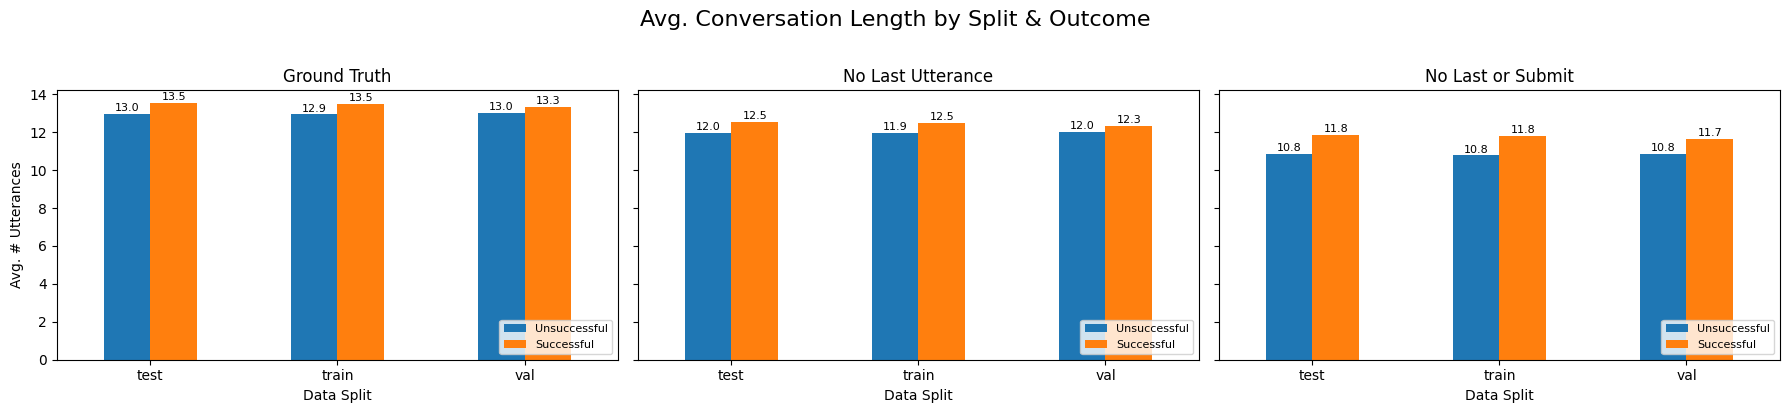

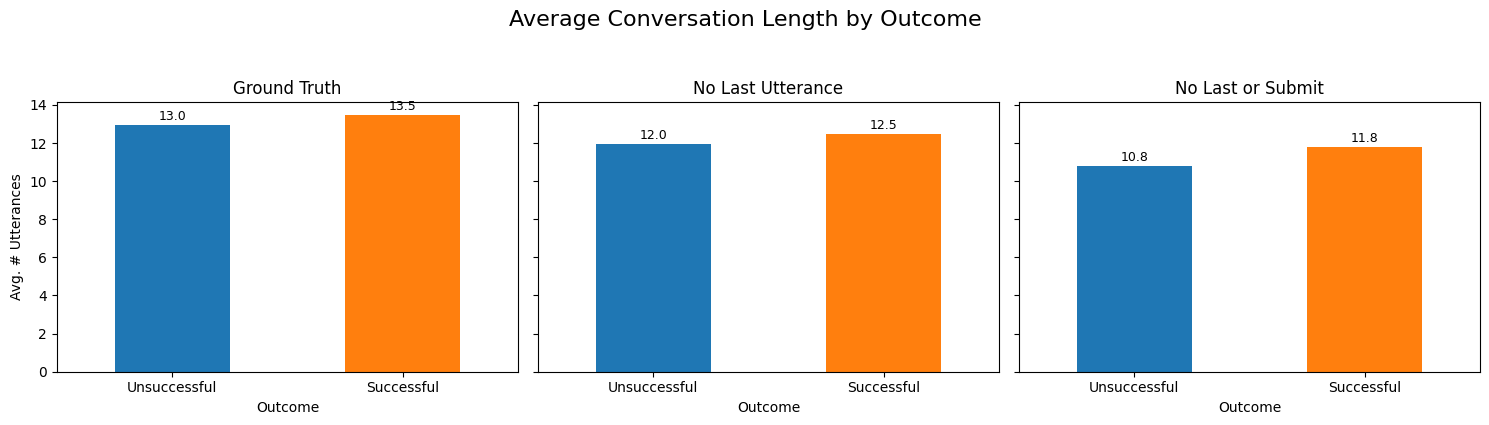

In [65]:
def compare_lengths_by_split(corpus_list, split_key="meta.split"):
    """
    For each (name, corpus) in corpus_list, make one subplot that shows
    the average conversation length (in # utterances) for each split × label.
    - split_key: the column in get_conversations_dataframe() holding your split
    """
    n = len(corpus_list)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 4), sharey=True)
    if n == 1:
        axes = [axes]
    
    for ax, (name, corpus) in zip(axes, corpus_list):
        # 1) utterance counts per conversation
        utts = corpus.get_utterances_dataframe()
        lengths_df = (
            utts
            .groupby("conversation_id")
            .size()
            .reset_index(name="length")
        )

        # 2) get split + label
        conv_meta = corpus.get_conversations_dataframe()
        conv_labels = (
            conv_meta
            .reset_index()
            .rename(columns={
                "id": "conversation_id",
                "meta.label": "label",
                split_key: "split"
            })[["conversation_id", "label", "split"]]
        )

        # 3) merge and compute mean length by split × label
        merged = lengths_df.merge(conv_labels, on="conversation_id")
        mean_by = (
            merged
            .groupby(["split", "label"])["length"]
            .mean()
            .unstack(fill_value=0)
            .rename(columns={0: "Unsuccessful", 1: "Successful"})
        )

        # 4) plot grouped bar chart
        mean_by.plot(
            kind="bar",
            ax=ax,
            rot=0,
            title=name
        )
        ax.set_xlabel("Data Split")
        if ax is axes[0]:
            ax.set_ylabel("Avg. # Utterances")

        # move legend to lower right
        ax.legend(loc="lower right", fontsize=8)

        # 5) annotate numeric values atop each bar
        for p in ax.patches:
            h = p.get_height()
            ax.text(
                p.get_x() + p.get_width()/2,
                h + 0.05,
                f"{h:.1f}",
                ha="center",
                va="bottom",
                fontsize=8
            )

    plt.suptitle("Avg. Conversation Length by Split & Outcome", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
def compare_lengths_by_label(corpus_list):
    """
    For each (name, corpus) in corpus_list, plot a bar chart of
    average conversation length (#utterances) for Successful (label=1)
    vs Unsuccessful (label=0).
    """
    n = len(corpus_list)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4), sharey=True)
    if n == 1:
        axes = [axes]
    
    for ax, (name, corpus) in zip(axes, corpus_list):
        # 1) get number of utterances per convo
        utts = corpus.get_utterances_dataframe()
       
        lengths = (
            utts
            .groupby("conversation_id")
            .size()
            .reset_index(name="length")
        )
    
        # 2) pull labels
        conv_meta = corpus.get_conversations_dataframe()
        labels = (
            conv_meta
            .reset_index()
            .loc[:, ["id", "meta.label"]]
            .rename(columns={"id":"conversation_id","meta.label":"label"})
        )
        # 3) merge and take mean by label
        df = lengths.merge(labels, on="conversation_id")
        avg_by_label = df.groupby("label")["length"].mean().rename({0:"Unsuccessful",1:"Successful"})
        
        # 4) plot
        avg_by_label.plot(kind="bar", ax=ax, rot=0, color=["C0","C1"])
        ax.set_title(name)
        ax.set_xlabel("Outcome")
        if ax is axes[0]:
            ax.set_ylabel("Avg. # Utterances")
        
        # annotate
        for p in ax.patches:
            ax.text(
                p.get_x()+p.get_width()/2,
                p.get_height()+0.1,
                f"{p.get_height():.1f}",
                ha="center", va="bottom", fontsize=9
            )
    
    plt.suptitle("Average Conversation Length by Outcome", y=1.05, fontsize=16)
    plt.tight_layout()
    plt.show()

compare_lengths_by_split([
    ("Ground Truth", corpus_kodis_ground),
    ("No Last Utterance", corpus_kodis_no_last),
    ("No Last or Submit", corpus_kodis_no_submit_last)
])

compare_lengths_by_label([
    ("Ground Truth", corpus_kodis_ground),
    ("No Last Utterance", corpus_kodis_no_last),
    ("No Last or Submit", corpus_kodis_no_submit_last)
])





### Downsample Successful Disputes (Train Split Only)

In [17]:
def downsample_train_to_balance(
    corpus: Corpus,
    split_key: str = "split",
    label_key: str = "label",
    seed: int = None
) -> Corpus:
    """
    Within the TRAIN split only, randomly remove conversations from the majority
    label until train has the same number of examples of each label.
    Val/test splits are left untouched.

    :param corpus:     your ConvoKit Corpus
    :param split_key:  conversation.meta field that holds your split tags
    :param label_key:  conversation.meta field that holds 0/1 labels
    :param seed:       for reproducibility
    :returns:          a filtered Corpus (in place) with a balanced train split
    """
    if seed is not None:
        random.seed(seed)

    # Collect train IDs by label
    train_ids = {0: [], 1: []}
    for convo in corpus.iter_conversations():
        if convo.meta.get(split_key) == "train":
            lbl = convo.meta.get(label_key)
            if lbl in train_ids:
                train_ids[lbl].append(convo.id)

    # Determine Minority in current split
    counts = {lbl: len(ids) for lbl, ids in train_ids.items()}
    minority_lbl, majority_lbl = min(counts, key=counts.get), max(counts, key=counts.get)
    target_n = counts[minority_lbl]

    # Random sampling majority class
    keep_majority = set(random.sample(train_ids[majority_lbl], target_n))
    keep_minority = set(train_ids[minority_lbl])
    keep_train_ids = keep_minority | keep_majority

    # Selector Helper
    def selector(convo):
        if convo.meta.get(split_key) != "train":
            return True
        return convo.id in keep_train_ids

    # 5) filter (in place) and return
    return corpus.filter_conversations_by(selector)


corpus_kodis_ground_downsampled = downsample_train_to_balance(corpus_kodis_ground,seed=42)
corpus_kodis_no_last_downsampled = downsample_train_to_balance(corpus_kodis_no_last, seed=42)
corpus_kodis_no_submit_last_downsampled = downsample_train_to_balance(corpus_kodis_no_submit_last,seed=42)


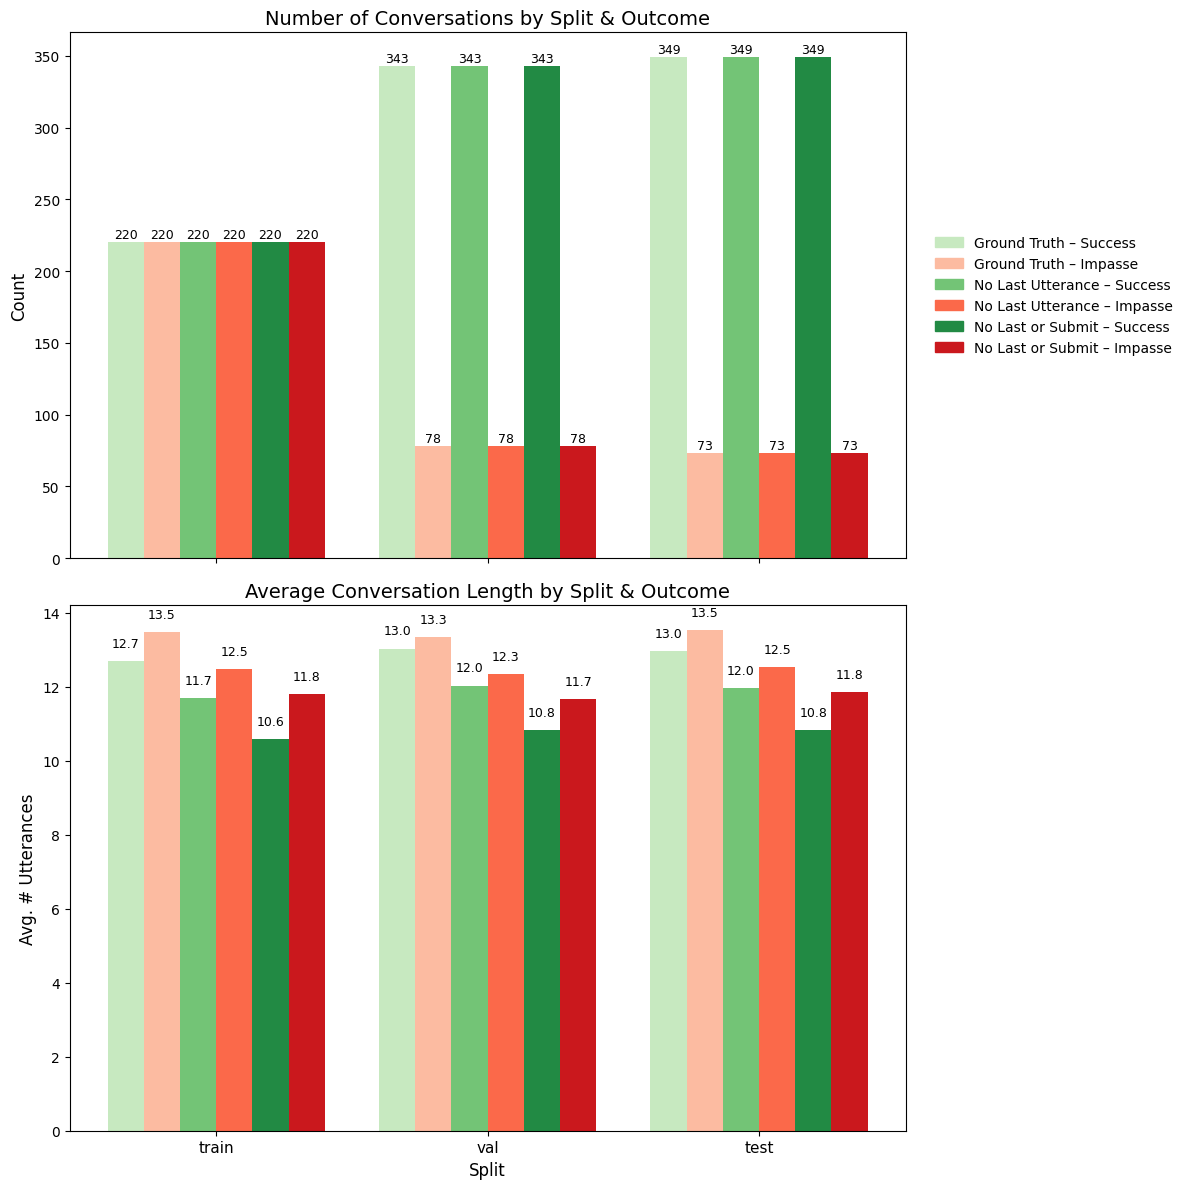

In [20]:

from matplotlib.patches import Patch

from matplotlib.patches import Patch
import numpy as np
import matplotlib.pyplot as plt

corpus_list = [
    ("Ground Truth", corpus_kodis_ground),
    ("No Last Utterance", corpus_kodis_no_last),
    ("No Last or Submit", corpus_kodis_no_submit_last)
]

def plot_counts_and_avg_lengths(corpus_list, split_key="split", length_func=None):
    """
    Stack two vertically:
      1) Counts by split & outcome
      2) Avg. length by split & outcome

    - No extra spacing between each Impasse/Success pair.
    - Each plot has its own x‑axis label.
    - Only one legend (on the top chart).
    - Now: label==1 → Impasse (red), label==0 → Success (green).
    """
    if length_func is None:
        length_func = lambda convo: len(convo.get_utterances_dataframe())

    # 1) discover splits
    all_splits = []
    for _, corpus in corpus_list:
        all_splits += [c.meta.get(split_key) for c in corpus.iter_conversations()]
    preferred = ["train", "val", "test"]
    splits = [s for s in preferred if s in all_splits] + sorted(set(all_splits) - set(preferred))
    n_splits = len(splits)

    n_corpi = len(corpus_list)
    labels  = [0,1]  # 0=Success, 1=Impasse

    # 2) bar geometry: no intra‑pair gap
    width     = 0.15
    block_w   = 2 * width     # Success + Impasse
    split_gap = width * 1.5    # gap between blocks
    group_step = n_corpi * block_w + split_gap
    group_centers = np.arange(n_splits) * group_step

    # 3) compute counts & avg lengths
    counts = np.zeros((n_corpi, n_splits, 2), int)
    avglen = np.zeros((n_corpi, n_splits, 2), float)
    for i, (_, corpus) in enumerate(corpus_list):
        buckets = {(sp,lab): [] for sp in splits for lab in labels}
        for convo in corpus.iter_conversations():
            sp, lab = convo.meta.get(split_key), convo.meta.get("label")
            if sp in splits and lab in labels:
                buckets[(sp,lab)].append(convo)
        for si, sp in enumerate(splits):
            for li, lab in enumerate(labels):
                convs = buckets[(sp,lab)]
                counts[i,si,li] = len(convs)
                avglen[i,si,li] = np.mean([length_func(c) for c in convs]) if convs else 0.0

    # 4) create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

    # 5) draw bars
    for i, (name, _) in enumerate(corpus_list):
        block_center = group_centers + (i - (n_corpi-1)/2) * block_w

        for li, lab in enumerate(labels):
            # now lab==1 → impasse → Reds, lab==0 → success → Greens
            cmap = plt.get_cmap("Reds")   if lab==1 else plt.get_cmap("Greens")
            color = cmap((i+1)/(n_corpi+1))

            # offset: success left, impasse right
            offset = block_center + (li*width - width/2)

            # top: counts
            ax1.bar(offset, counts[i,:,lab], width, color=color)
            for si in range(n_splits):
                h = counts[i,si,lab]
                ax1.text(offset[si], h+1, str(h),
                         ha="center", va="bottom", fontsize=9)

            # bottom: avg length
            ax2.bar(offset, avglen[i,:,lab], width, color=color)
            for si in range(n_splits):
                h2 = avglen[i,si,lab]
                ax2.text(offset[si], h2+0.3, f"{h2:.1f}",
                         ha="center", va="bottom", fontsize=9)

    # 6) legend: one entry per corpus×outcome
    legend_handles = []
    legend_labels  = []
    for i, (name, _) in enumerate(corpus_list):
        for lab in labels:
            cmap = plt.get_cmap("Reds")   if lab==1 else plt.get_cmap("Greens")
            color = cmap((i+1)/(n_corpi+1))
            label = f"{name} – {'Impasse' if lab==1 else 'Success'}"
            legend_handles.append(Patch(color=color))
            legend_labels.append(label)
    ax1.legend(legend_handles, legend_labels,
               fontsize=10, frameon=False,
               bbox_to_anchor=(1.02, 0.5), loc="center left")

    # 7) format top
    ax1.set_title("Number of Conversations by Split & Outcome", fontsize=14)
    ax1.set_ylabel("Count", fontsize=12)
    ax1.set_xticks(group_centers)
    ax1.set_xticklabels([])             # no x‑labels on top
    ax1.set_xlabel("")                  # clear x‑label

    # 8) format bottom
    ax2.set_title("Average Conversation Length by Split & Outcome", fontsize=14)
    ax2.set_ylabel("Avg. # Utterances", fontsize=12)
    ax2.set_xticks(group_centers)
    ax2.set_xticklabels(splits, fontsize=11, rotation=0)
    ax2.set_xlabel("Split", fontsize=12)

    plt.tight_layout()
    plt.show()


plot_counts_and_avg_lengths(corpus_list)


### Full Training Pipeline

In [ ]:
""" New Testing Corpus """
ground1 = corp.corpusBuilder(final_data) 
ground2= corp.corpusBuilder(final_data)
ground3=corp.corpusBuilder(final_data)
add_convo_labels(ground1, final_data)
add_convo_labels(ground2, final_data)
add_convo_labels(ground3, final_data)
corpus_train_test_split(ground1)
corpus_train_test_split(ground2)
corpus_train_test_split(ground3)

DEFAULT_CONFIG_downsampled = {
    "dropout": 0.1,
    "batch_size": 64,
    "clip": 50.0,
    "learning_rate": 1e-5,
    "print_every": 10,
    "finetune_epochs":35,
    "validation_size": 0.2,
}

""" Model Creation """

model_ground_downsampled = CRAFTModel(
    initial_weights=model,
    torch_device=DEVICE,
    vocab_index2word=vocab_i2w,
    vocab_word2index=vocab_w2i,
    config = DEFAULT_CONFIG_downsampled
    
)

model_no_last_downsampled = CRAFTModel(
    initial_weights=model,
    torch_device=DEVICE,
    vocab_index2word=vocab_i2w,
    vocab_word2index=vocab_w2i, 
    config=DEFAULT_CONFIG_downsampled
)
model_no_submit_last_downsampled = CRAFTModel(
    initial_weights=model,
    torch_device=DEVICE,
    vocab_index2word=vocab_i2w,
    vocab_word2index=vocab_w2i,
    config=DEFAULT_CONFIG_downsampled
)
"""Forecaster Model Creation """
forecaster_kodis_ground_downsampled = Forecaster(
    forecaster_model=model_ground_downsampled,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)
forecaster_kodis_no_last_downsampled = Forecaster(
    forecaster_model= model_no_last_downsampled,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)
forecaster_kodis_no_last_submit_downsampled = Forecaster(
    forecaster_model= model_no_submit_last_downsampled,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)

"""Training """
forecaster_kodis_ground_downsampled.fit(
    corpus_kodis_ground_downsampled, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

forecaster_kodis_no_last_downsampled.fit(
    corpus_kodis_no_last_downsampled, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))

forecaster_kodis_no_last_submit_downsampled.fit(
    corpus_kodis_no_submit_last_downsampled, 
    context_selector=partial(fit_selector, split="train"), 
    val_context_selector=partial(fit_selector, split="val"))
    
"""Testing"""
corpus_kodis_ground_orig = forecaster_kodis_ground_downsampled.transform(ground1, transform_selector)
ground_downsampled_df, ground_downsampled_metrics = forecaster_kodis_ground_downsampled.summarize(corpus_kodis_ground_orig, convo_selector)
groun_horizon_downsampled = forecaster_kodis_ground_downsampled._draw_horizon_plot(corpus_kodis_ground_orig, convo_selector)


corpus_kodis_ground_nl = forecaster_kodis_no_last_downsampled.transform(ground2, transform_selector)
no_last_downsampled_df, no_last_downsampled_metrics = forecaster_kodis_no_last_downsampled.summarize(corpus_kodis_ground_nl , convo_selector)
no_last_horizon_downsampled = forecaster_kodis_no_last_downsampled._draw_horizon_plot(corpus_kodis_ground_nl, convo_selector)

corpus_kodis_ground_nls = forecaster_kodis_no_last_submit_downsampled.transform(ground3, transform_selector)
no_last_submit_downsampled_df, no_last_submit_downsampled_metrics = forecaster_kodis_no_last_submit_downsampled.summarize(corpus_kodis_ground_nls,convo_selector)
no_last_submit_horizon_downsampled = forecaster_kodis_no_last_submit_downsampled._draw_horizon_plot(corpus_kodis_ground_nls, convo_selector)


### Saving Results

In [ ]:
save_downsampled()

### Plotting Results (Conversation Level Aggregation)

In [ ]:

corpora_info_downsampled = [
    ("KODIS_NO_LAST_SUBMIT", corpus_kodis_ground, no_last_submit_downsampled_metrics, no_last_submit_downsampled_df, no_last_submit_horizon_downsampled),
    ("KODIS_NO_LAST",         corpus_kodis_ground, no_last_downsampled_metrics,  no_last_downsampled_df,  no_last_horizon_downsampled),
    ("KODIS_GROUND",          corpus_kodis_ground, ground_downsampled_metrics, ground_downsampled_df, groun_horizon_downsampled)
]
compare_craft_models(corpora_info_downsampled)



# Testing on Fine-Tuned Wiki Model

In [ ]:
""" New Testing Corpus """
ground1 = corp.corpusBuilder(final_data) 
ground2= corp.corpusBuilder(final_data_no_last)
ground3=corp.corpusBuilder(final_data_no_submit_last)
add_convo_labels(ground1, final_data)
add_convo_labels(ground2, final_data)
add_convo_labels(ground3, final_data)
corpus_train_test_split(ground1)
corpus_train_test_split(ground2)
corpus_train_test_split(ground3)


""" CRAFT MODEL INSTANCES """
model_wiki = CRAFTModel(
    initial_weights= "craft-wiki-finetuned",  # or "craft-wiki-finetuned"
    torch_device="cuda" if torch.cuda.is_available() else "cpu"
)


""" FORECASTER MODEL INSTANCE """
forecaster_kodis_wiki = Forecaster(
    forecaster_model= model_wiki,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)


"""Testing"""
corpus_kodis_ground_orig = forecaster_kodis_wiki.transform(ground1, transform_selector)
ground_wiki_df, ground_wiki_metrics = forecaster_kodis_wiki.summarize(corpus_kodis_ground_orig, convo_selector)
ground_wiki_horizon =forecaster_kodis_wiki._draw_horizon_plot(corpus_kodis_ground_orig, convo_selector)

corpus_kodis_ground_nl = forecaster_kodis_wiki.transform(ground2, transform_selector)
no_last_wiki_df, no_last_wiki_metrics = forecaster_kodis_wiki.summarize(corpus_kodis_ground_nl , convo_selector)
no_last_wiki_horizon = forecaster_kodis_wiki._draw_horizon_plot(corpus_kodis_ground_nl, convo_selector)

corpus_kodis_ground_nls = forecaster_kodis_wiki.transform(ground3, transform_selector)
no_last_submit_wiki_df, no_last_submit_wiki_metrics = forecaster_kodis_wiki.summarize(corpus_kodis_ground_nls,convo_selector)
no_last_submit_horizon = forecaster_kodis_wiki._draw_horizon_plot(corpus_kodis_ground_nls, convo_selector)


### Plotting Results

In [ ]:
best_thresholds_wiki, best_metrics_wiki, best_corpora_wiki =compare_craft_models(
    [
        ("KODIS_NO_LAST_SUBMIT", corpus_kodis_ground_orig, no_last_submit_wiki_metrics, no_last_submit_wiki_df, no_last_submit_horizon),
        ("KODIS_NO_LAST",         corpus_kodis_ground_nl, no_last_wiki_metrics,  no_last_wiki_df,  no_last_wiki_horizon),
        ("KODIS_WIKI",          corpus_kodis_ground_nls, ground_wiki_metrics, ground_wiki_df, ground_wiki_horizon),
    ]
)
compare_best_models(best_thresholds_wiki, best_metrics_wiki, best_corpora_wiki)
wiki ={}
wiki["ground_corpus"] = corpus_kodis_ground_orig
wiki["ground_metrics"] = ground_wiki_metrics
wiki["ground_df"] =  ground_wiki_df
wiki["ground_horizon"] = ground_wiki_horizon

wiki["no_last_corpus"] = corpus_kodis_ground_nl
wiki["no_last_metrics"] = no_last_wiki_metrics
wiki["no_last_df"] =  no_last_wiki_df
wiki["no_last_horizon"] = no_last_wiki_horizon

wiki["no_last_submit_corpus"] = corpus_kodis_ground_nls
wiki["no_last_submit_metrics"] = no_last_submit_wiki_metrics
wiki["no_last_submit_df"] =  no_last_submit_wiki_df
wiki["no_last_submit_horizon"] = no_last_submit_horizon

# Analysis Across All Experiments

## Ground Model Performance Comparison Across Default, Weighted,Downsampled Variants

== Avg. Conversation Length ==
  GROUND_DEFAULT        train=13.0  test=13.1
  GROUND_WEIGHTED       train=13.1  test=13.1
  GROUND_DOWNSAMPLED    train=13.0  test=13.1
  GROUND_WIKI           train=13.0  test=13.1

== Conversation‑level Test Metrics ==


Accuracy  Precision    Recall       FPR        F1
GROUND_DEFAULT      0.303318   0.198910  1.000000  0.842407  0.331818
GROUND_WEIGHTED     0.175355   0.173397  1.000000  0.997135  0.295547
GROUND_DOWNSAMPLED  0.172986   0.172986  1.000000  1.000000  0.294949
GROUND_WIKI         0.443128   0.228188  0.931507  0.659026  0.366577

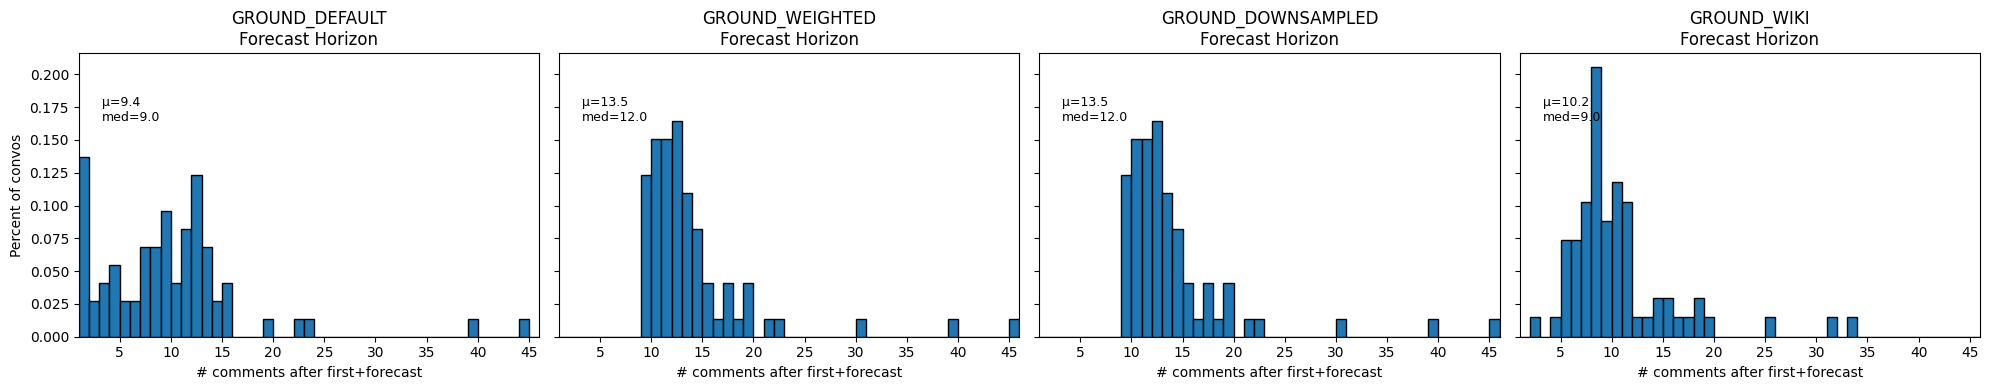

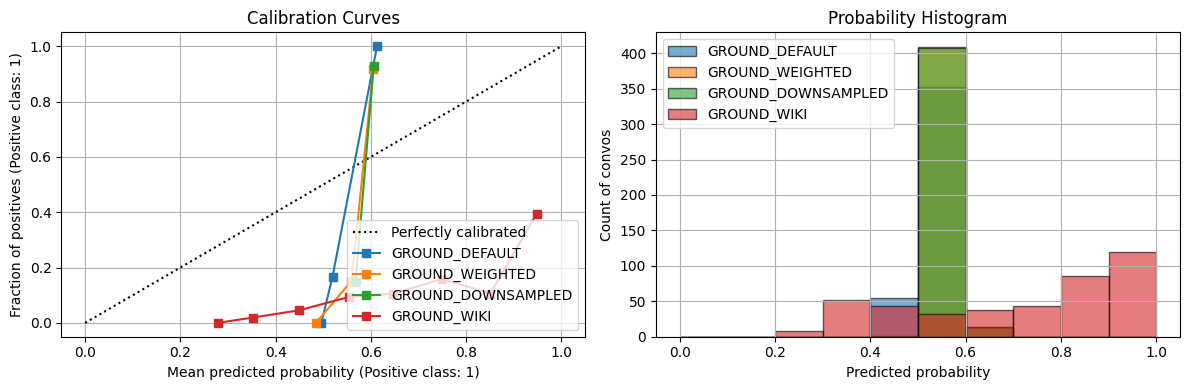

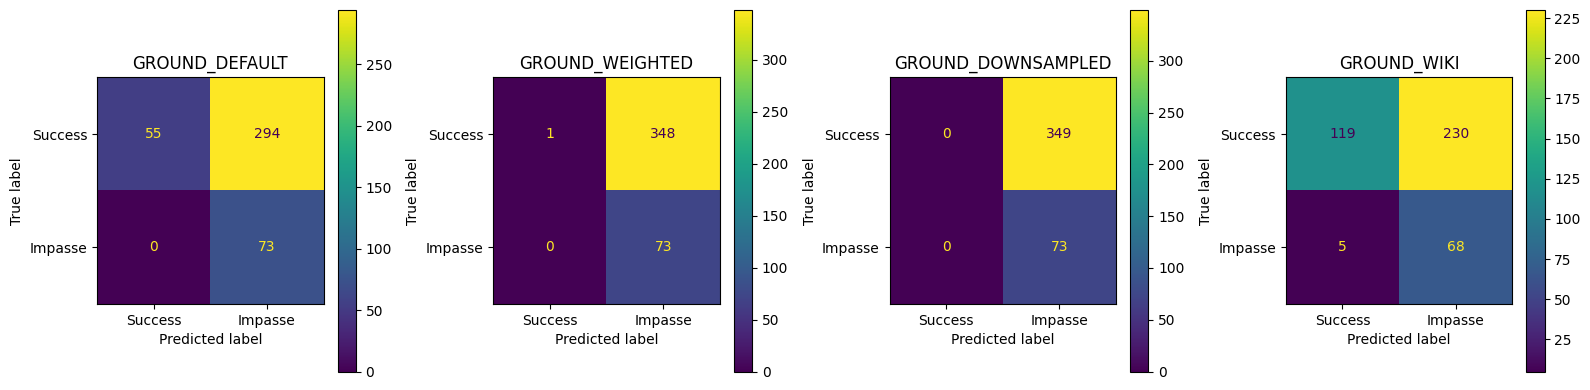

GROUND_DEFAULT       best thr=0.541, TPR=1.000, FPR=0.000, J=1.000
GROUND_WEIGHTED      best thr=0.575, TPR=0.699, FPR=0.072, J=0.627
GROUND_DOWNSAMPLED   best thr=0.581, TPR=0.671, FPR=0.112, J=0.559
GROUND_WIKI          best thr=0.872, TPR=0.740, FPR=0.264, J=0.476


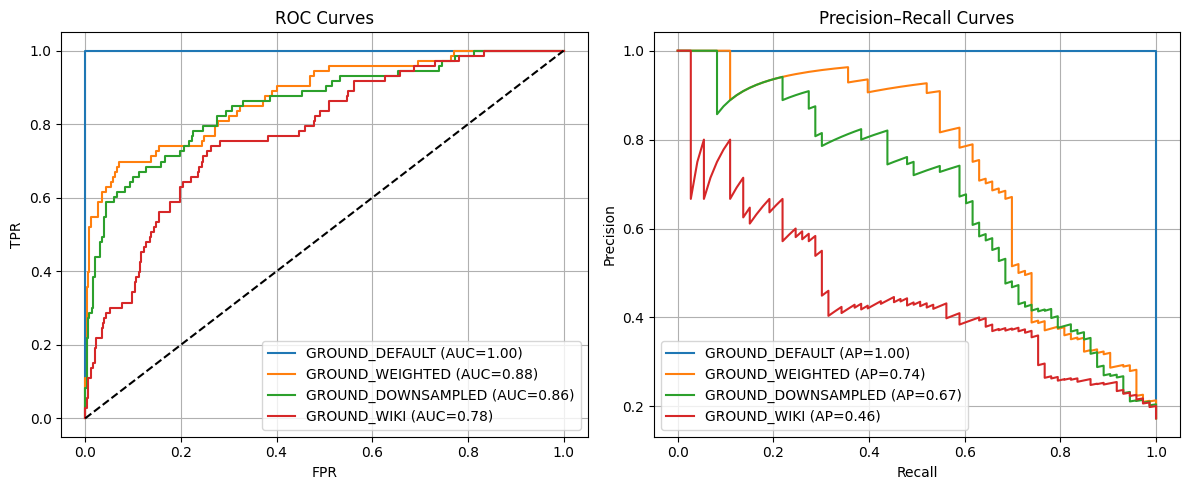

== Summary of Convo Acc & Avg Prob ==


GROUND_DEFAULT_acc  GROUND_WEIGHTED_acc  \
conversation_level            0.303318             0.175355   

                    GROUND_DOWNSAMPLED_acc  GROUND_WIKI_acc  \
conversation_level                0.172986         0.443128   

                    GROUND_DEFAULT_avg_prob  GROUND_WEIGHTED_avg_prob  \
conversation_level                 0.519425                  0.560313   

                    GROUND_DOWNSAMPLED_avg_prob  GROUND_WIKI_avg_prob  
conversation_level                      0.56887              0.712573

In [128]:
corpora_info_ground = [
    (
        "GROUND_DEFAULT",
        no_samp   ["ground_corpus"],
        no_samp   ["ground_metrics"],
        no_samp   ["ground_df"],
        no_samp   ["ground_horizon"],
    ),
    (
        "GROUND_WEIGHTED",
        wt        ["ground_corpus"],
        wt        ["ground_metrics"],
        wt        ["ground_df"],
        wt        ["ground_horizon"],
    ),
    (
        "GROUND_DOWNSAMPLED",
        down      ["ground_corpus"],
        down      ["ground_metrics"],
        down      ["ground_df"],
        down      ["ground_horizon"],
    ),
    (
        "GROUND_WIKI",
        wiki      ["ground_corpus"],
        wiki      ["ground_metrics"],
        wiki      ["ground_df"],
        wiki      ["ground_horizon"],
    )
]

best_thresholds_ground, best_metrics_ground, best_corpora_ground = compare_craft_models(corpora_info_ground)

### Best Threshold Performance Comparison

== Conversation‑level Best Threshold Test Set Metrics ==


Accuracy  Precision    Recall       FPR        F1  \
GROUND_DEFAULT      1.000000   1.000000  1.000000  0.000000  1.000000   
GROUND_WEIGHTED     0.827014   0.000000  0.000000  0.000000  0.000000   
GROUND_DOWNSAMPLED  0.850711   0.556818  0.671233  0.111748  0.608696   
GROUND_WIKI         0.736967   0.369863  0.739726  0.263610  0.493151   

                    Threshold  
GROUND_DEFAULT       0.541032  
GROUND_WEIGHTED      0.575249  
GROUND_DOWNSAMPLED   0.580783  
GROUND_WIKI          0.871697

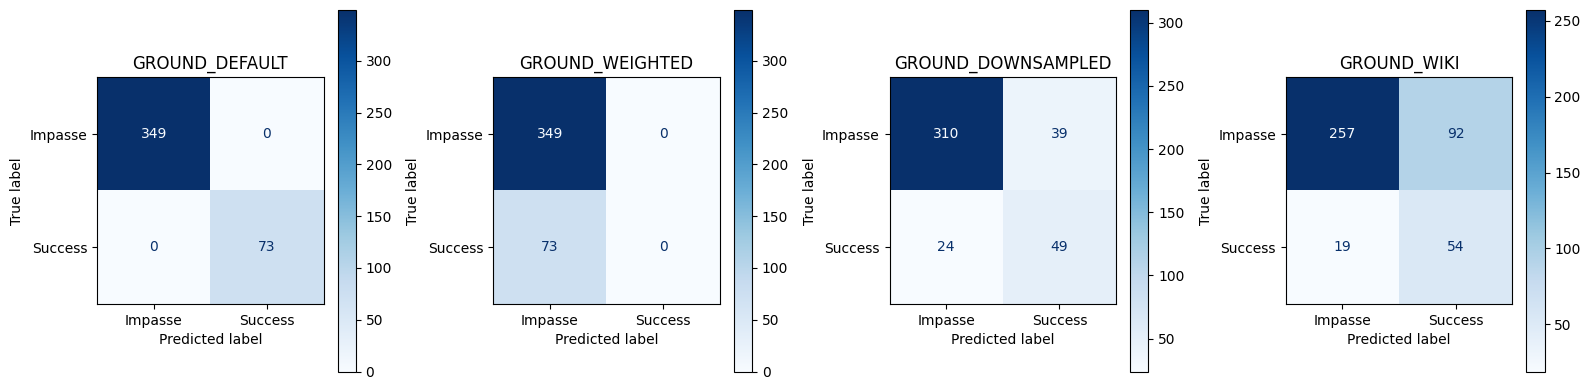

/root/venv/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


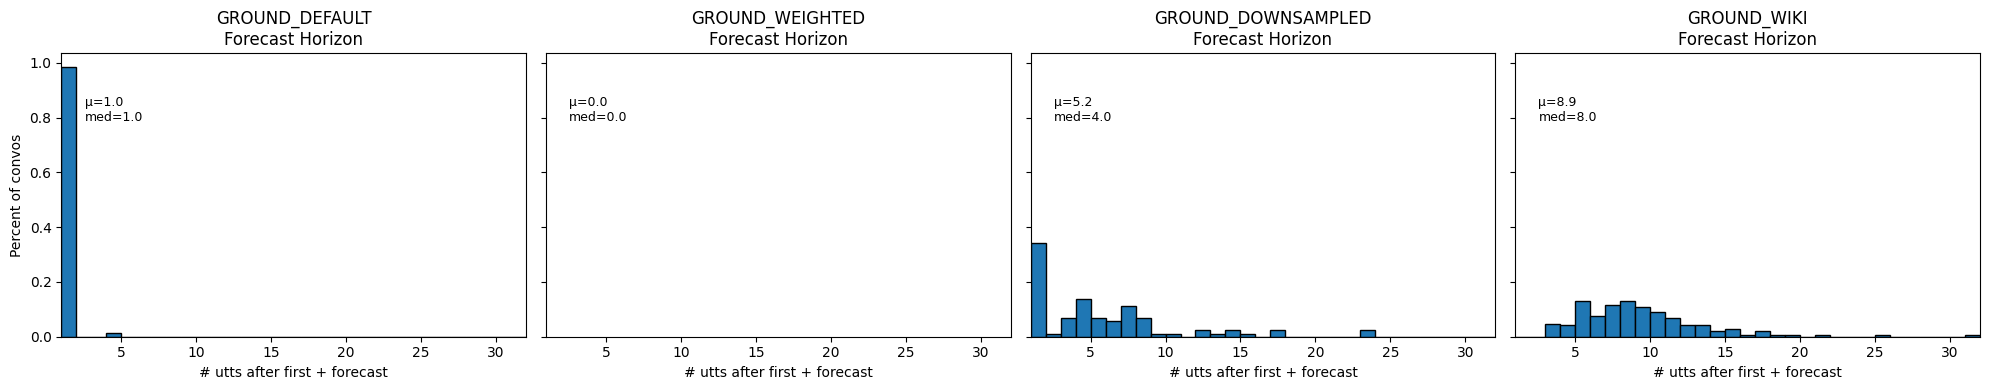

In [131]:
compare_best_models(best_thresholds_ground, best_metrics_ground, best_corpora_ground)

## No Last Utterance Model Performance Comparison Across Default, Weighted,Downsampled Variants

== Avg. Conversation Length ==
  NO_LAST_DEFAULT       train=13.0  test=13.1
  NO_LAST_WEIGHTED      train=13.1  test=13.1
  NO_LAST_DOWNSAMPLED   train=13.0  test=13.1
  GROUND_WIKI           train=13.0  test=13.1

== Conversation‑level Test Metrics ==


Accuracy  Precision    Recall       FPR        F1
NO_LAST_DEFAULT      0.175355   0.173397  1.000000  0.997135  0.295547
NO_LAST_WEIGHTED     0.172986   0.172986  1.000000  1.000000  0.294949
NO_LAST_DOWNSAMPLED  0.172986   0.172986  1.000000  1.000000  0.294949
GROUND_WIKI          0.443128   0.228188  0.931507  0.659026  0.366577

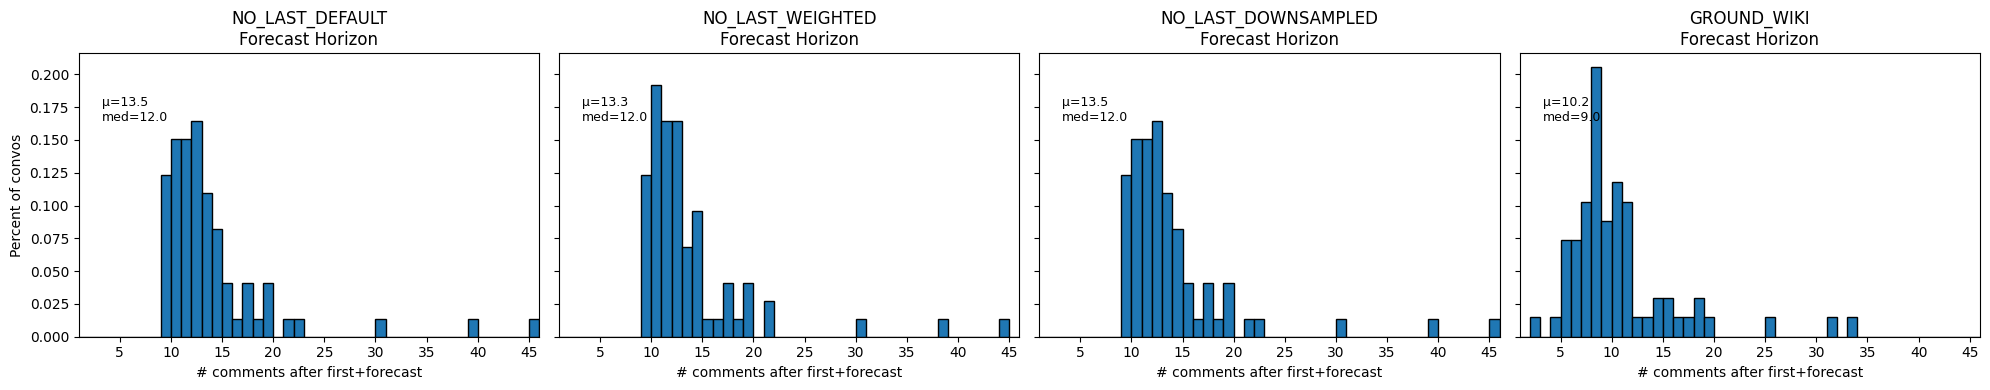

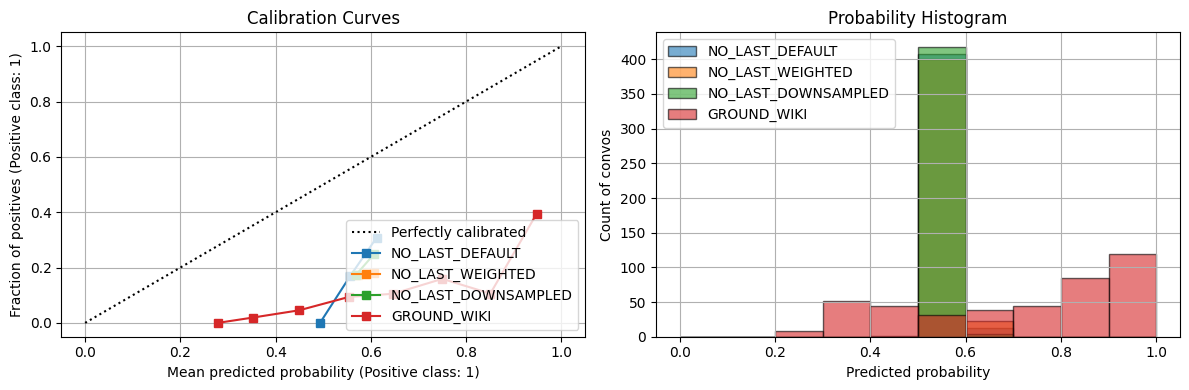

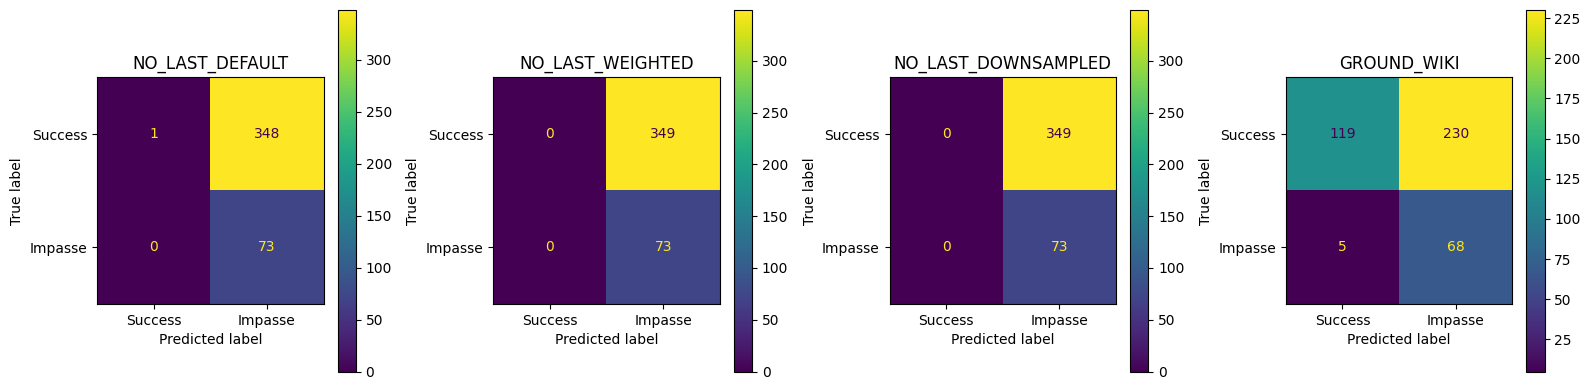

NO_LAST_DEFAULT      best thr=0.555, TPR=0.699, FPR=0.499, J=0.200
NO_LAST_WEIGHTED     best thr=0.577, TPR=0.630, FPR=0.441, J=0.189
NO_LAST_DOWNSAMPLED  best thr=0.560, TPR=0.890, FPR=0.665, J=0.226
GROUND_WIKI          best thr=0.872, TPR=0.740, FPR=0.264, J=0.476


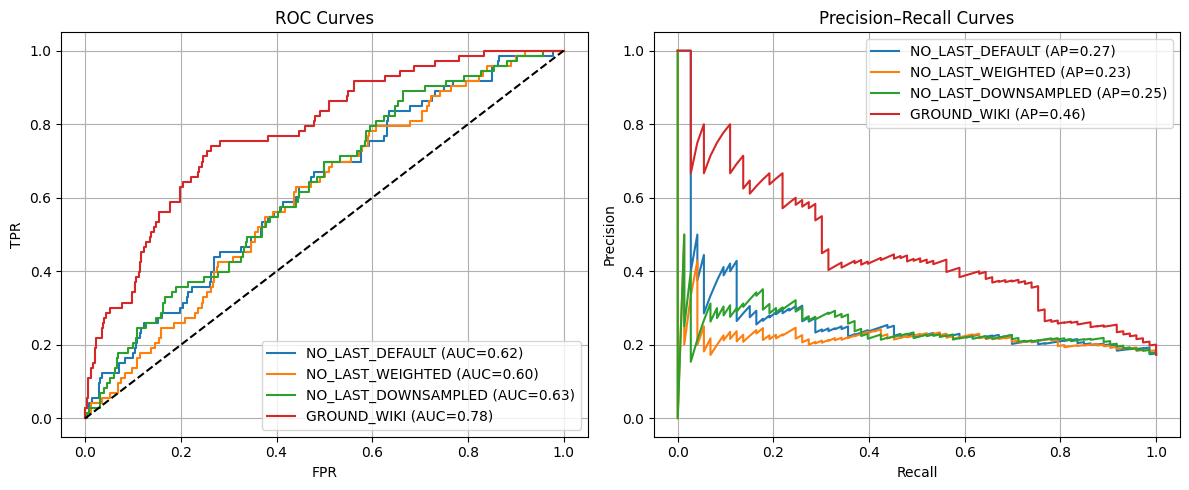

== Summary of Convo Acc & Avg Prob ==


NO_LAST_DEFAULT_acc  NO_LAST_WEIGHTED_acc  \
conversation_level             0.175355              0.172986   

                    NO_LAST_DOWNSAMPLED_acc  GROUND_WIKI_acc  \
conversation_level                 0.172986         0.443128   

                    NO_LAST_DEFAULT_avg_prob  NO_LAST_WEIGHTED_avg_prob  \
conversation_level                  0.557905                   0.574563   

                    NO_LAST_DOWNSAMPLED_avg_prob  GROUND_WIKI_avg_prob  
conversation_level                      0.568332              0.712573

In [134]:
corpora_info_no_last = [
    (
        "NO_LAST_DEFAULT",
        no_samp["no_last_corpus"],
        no_samp["no_last_metrics"],
        no_samp["no_last_df"],
        no_samp["no_last_horizon"],
    ),
    (
        "NO_LAST_WEIGHTED",
        wt["no_last_corpus"],
        wt["no_last_metrics"],
        wt["no_last_df"],
        wt["no_last_horizon"],
    ),
    (
        "NO_LAST_DOWNSAMPLED",
        down["no_last_corpus"],
        down["no_last_metrics"],
        down["no_last_df"],
        down["no_last_horizon"],
    ),
    (
        "GROUND_WIKI",
        wiki      ["ground_corpus"],
        wiki      ["ground_metrics"],
        wiki      ["ground_df"],
        wiki      ["ground_horizon"],
    )
]

best_thresholds_no_last, best_metrics_no_last, best_corpora_no_last = compare_craft_models(corpora_info_no_last)

### Best Threshold Performance Comparison

== Conversation‑level Best Threshold Test Set Metrics ==


Accuracy  Precision    Recall       FPR        F1  \
NO_LAST_DEFAULT      0.535545   0.226667  0.698630  0.498567  0.342282   
NO_LAST_WEIGHTED     0.827014   0.000000  0.000000  0.000000  0.000000   
NO_LAST_DOWNSAMPLED  0.431280   0.218855  0.890411  0.664756  0.351351   
GROUND_WIKI          0.736967   0.369863  0.739726  0.263610  0.493151   

                     Threshold  
NO_LAST_DEFAULT       0.555385  
NO_LAST_WEIGHTED      0.576696  
NO_LAST_DOWNSAMPLED   0.559719  
GROUND_WIKI           0.871697

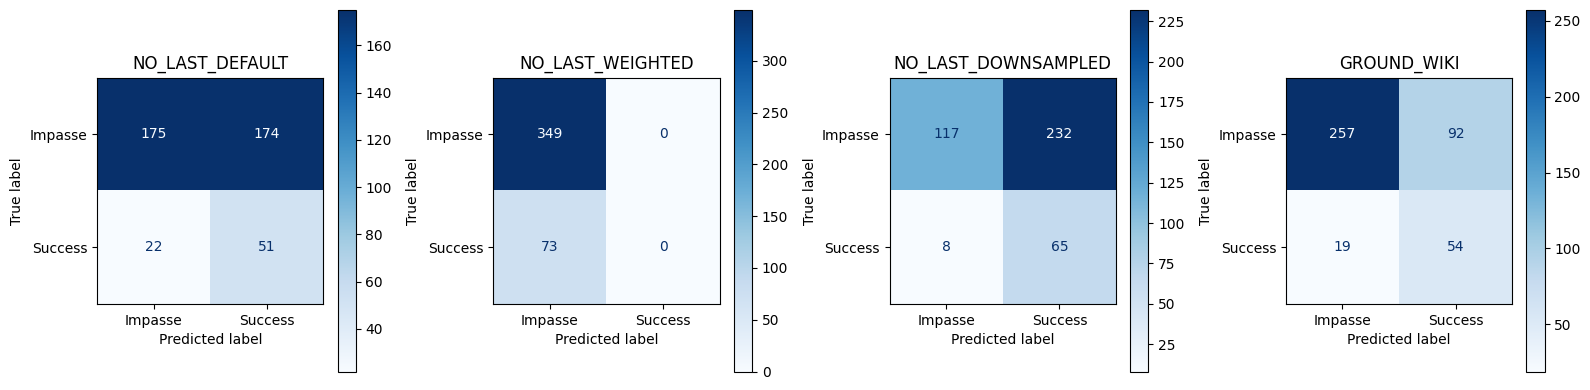

/root/venv/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


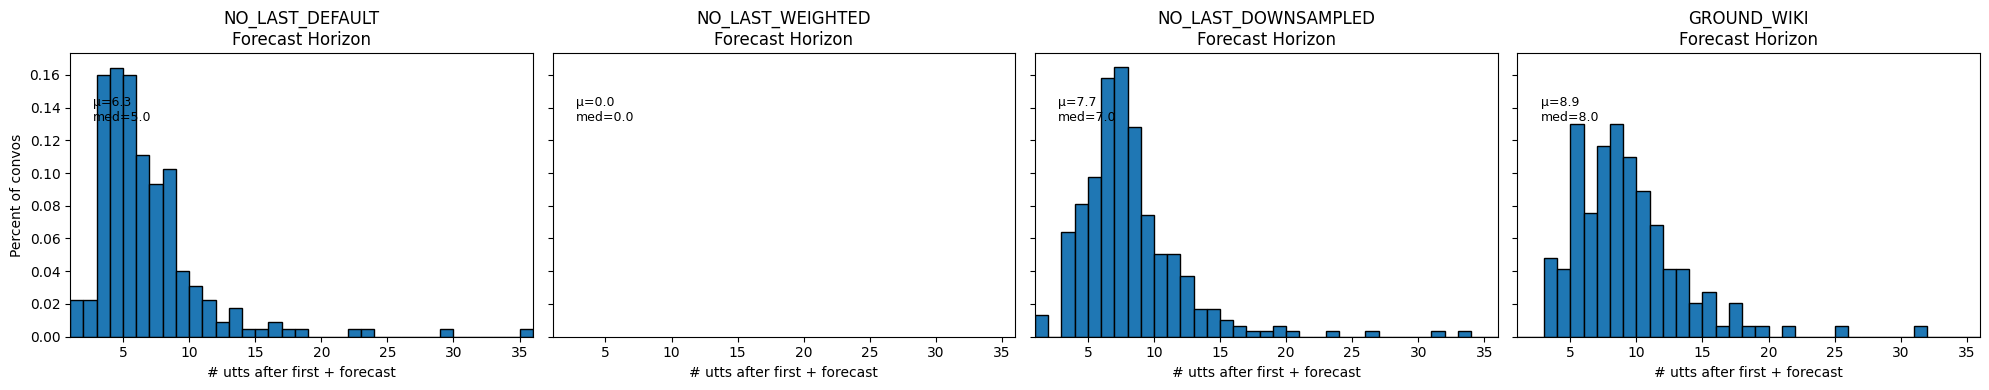

In [137]:
compare_best_models(best_thresholds_no_last, best_metrics_no_last, best_corpora_no_last)

## No Last/No Submit Model Performance Comparison Across Default, Weighted, Downsampled Variants

== Avg. Conversation Length ==
  NO_LAST_SUBMIT_DEFAULT  train=13.0  test=13.1
  NO_LAST_SUBMIT_WEIGHTED  train=13.1  test=13.1
  NO_LAST_SUBMIT_DOWNSAMPLED  train=13.0  test=13.1
  GROUND_WIKI           train=13.0  test=13.1

== Conversation‑level Test Metrics ==


Accuracy  Precision    Recall       FPR        F1
NO_LAST_SUBMIT_DEFAULT      0.670616   0.318681  0.794521  0.355301  0.454902
NO_LAST_SUBMIT_WEIGHTED     0.777251   0.370370  0.410959  0.146132  0.389610
NO_LAST_SUBMIT_DOWNSAMPLED  0.255924   0.188630  1.000000  0.899713  0.317391
GROUND_WIKI                 0.443128   0.228188  0.931507  0.659026  0.366577

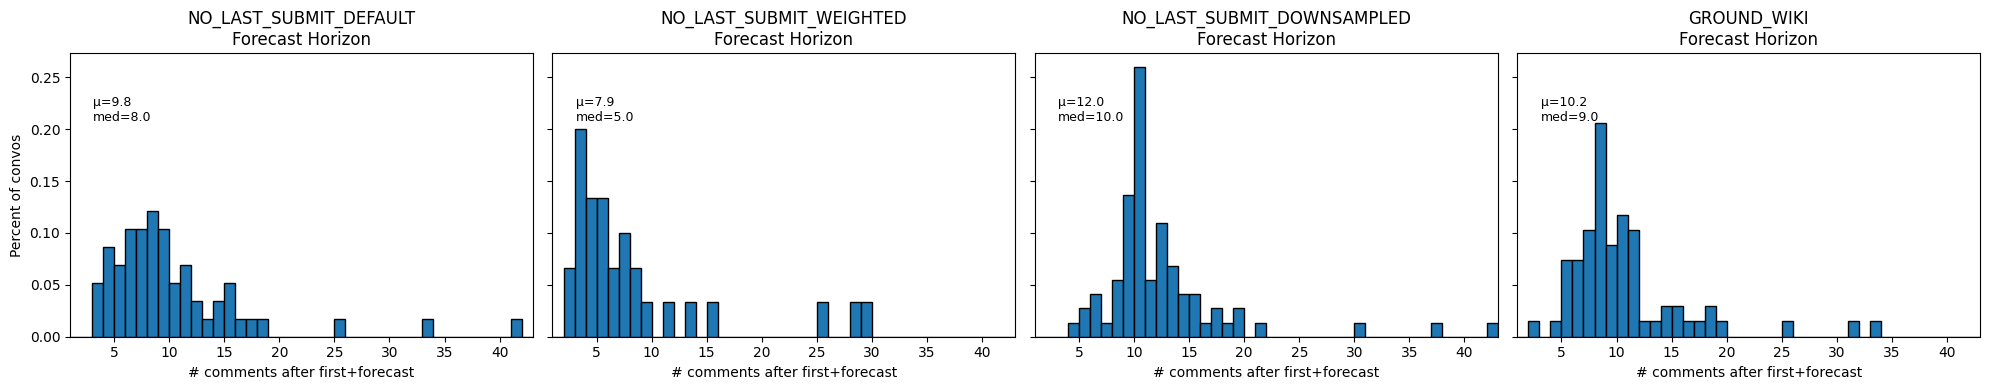

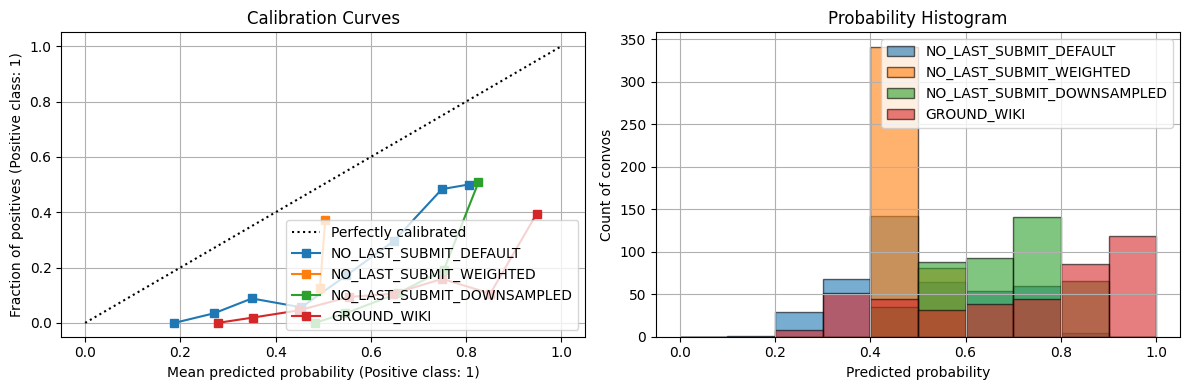

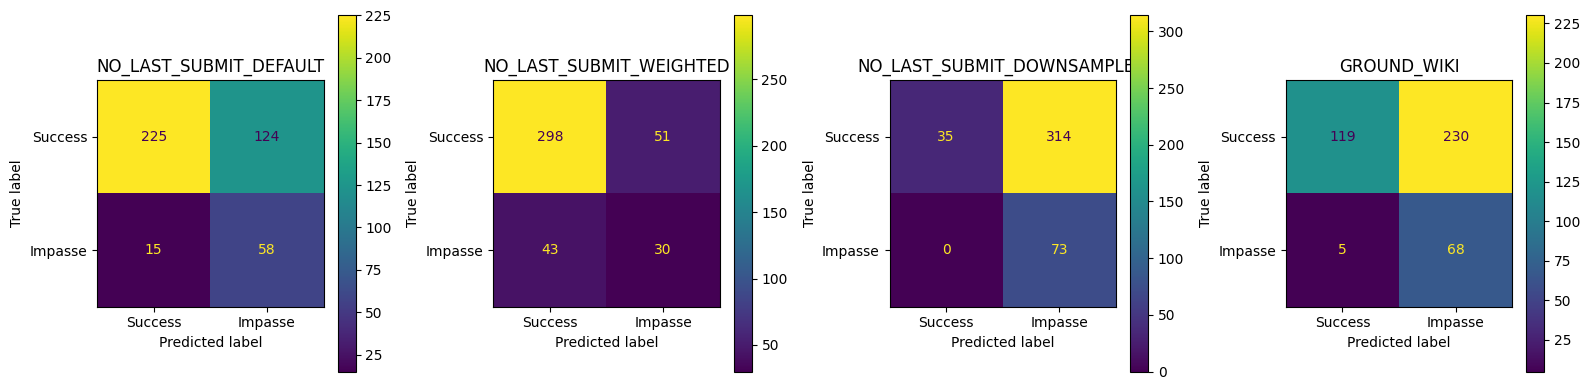

NO_LAST_SUBMIT_DEFAULT best thr=0.521, TPR=0.781, FPR=0.321, J=0.460
NO_LAST_SUBMIT_WEIGHTED best thr=0.497, TPR=0.699, FPR=0.252, J=0.446
NO_LAST_SUBMIT_DOWNSAMPLED best thr=0.758, TPR=0.753, FPR=0.232, J=0.521
GROUND_WIKI          best thr=0.872, TPR=0.740, FPR=0.264, J=0.476


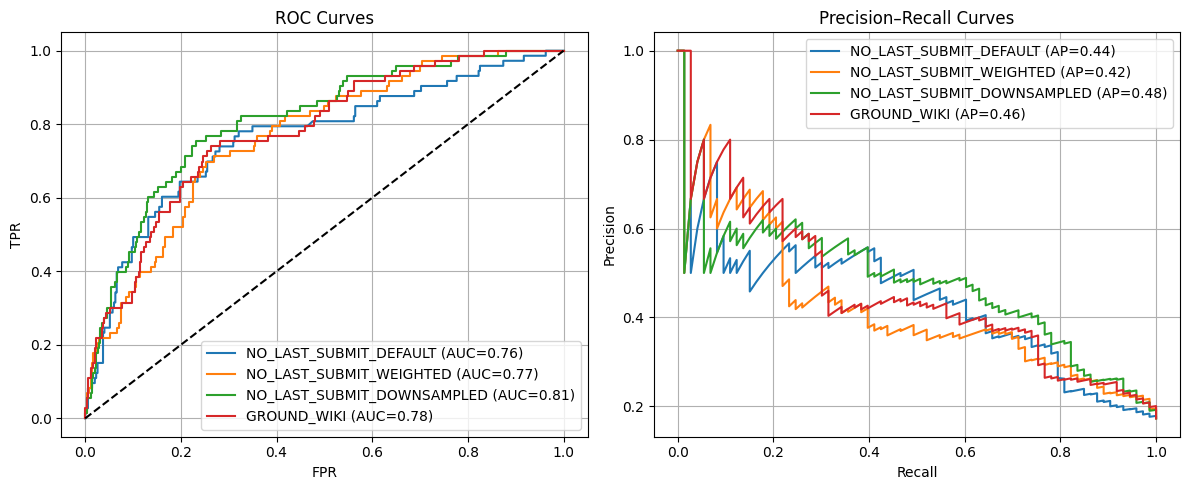

== Summary of Convo Acc & Avg Prob ==


NO_LAST_SUBMIT_DEFAULT_acc  NO_LAST_SUBMIT_WEIGHTED_acc  \
conversation_level                    0.670616                     0.777251   

                    NO_LAST_SUBMIT_DOWNSAMPLED_acc  GROUND_WIKI_acc  \
conversation_level                        0.255924         0.443128   

                    NO_LAST_SUBMIT_DEFAULT_avg_prob  \
conversation_level                         0.508492   

                    NO_LAST_SUBMIT_WEIGHTED_avg_prob  \
conversation_level                          0.495041   

                    NO_LAST_SUBMIT_DOWNSAMPLED_avg_prob  GROUND_WIKI_avg_prob  
conversation_level                             0.677392              0.712573

In [140]:

corpora_info_no_subm = [
    (
        "NO_LAST_SUBMIT_DEFAULT",
        no_samp["no_subm_corpus"],
        no_samp["no_subm_metrics"],
        no_samp["no_subm_df"],
        no_samp["no_subm_horizon"],
    ),
    (
        "NO_LAST_SUBMIT_WEIGHTED",
        wt["no_subm_corpus"],
        wt["no_subm_metrics"],
        wt["no_subm_df"],
        wt["no_subm_horizon"],
    ),
    (
        "NO_LAST_SUBMIT_DOWNSAMPLED",
        down["no_subm_corpus"],
        down["no_subm_metrics"],
        down["no_subm_df"],
        down["no_subm_horizon"],
    ), (
        "GROUND_WIKI",
        wiki      ["ground_corpus"],
        wiki      ["ground_metrics"],
        wiki      ["ground_df"],
        wiki      ["ground_horizon"],
    )
]

no_last_submit_thresholds, no_last_submit_metrics, no_last_submit_corpora = compare_craft_models(corpora_info_no_subm)

### Best Threshold Model Performance Comparison

== Conversation‑level Best Threshold Test Set Metrics ==


Accuracy  Precision    Recall       FPR        F1  \
NO_LAST_SUBMIT_DEFAULT      0.696682   0.337278  0.780822  0.320917  0.471074   
NO_LAST_SUBMIT_WEIGHTED     0.739336   0.366906  0.698630  0.252149  0.481132   
NO_LAST_SUBMIT_DOWNSAMPLED  0.765403   0.404412  0.753425  0.232092  0.526316   
GROUND_WIKI                 0.736967   0.369863  0.739726  0.263610  0.493151   

                            Threshold  
NO_LAST_SUBMIT_DEFAULT       0.521406  
NO_LAST_SUBMIT_WEIGHTED      0.497068  
NO_LAST_SUBMIT_DOWNSAMPLED   0.757998  
GROUND_WIKI                  0.871697

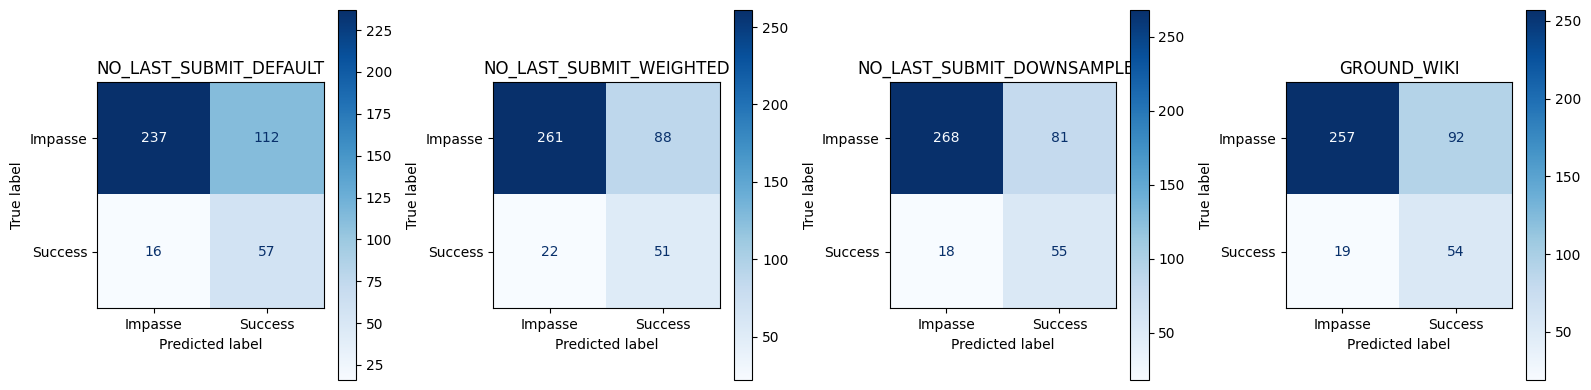

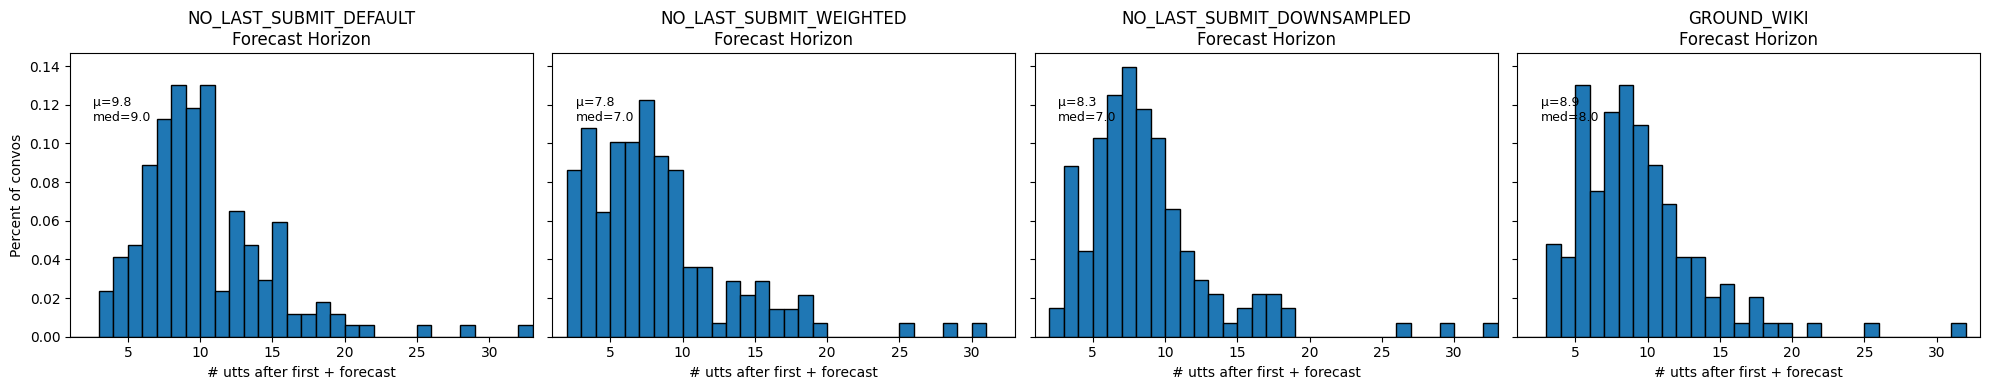

In [143]:
compare_best_models(no_last_submit_thresholds, no_last_submit_metrics, no_last_submit_corpora)

# Conversation Forecasting Trends

## Ground Model Performance Comparison Across Default, Weighted, Downsampled Variants

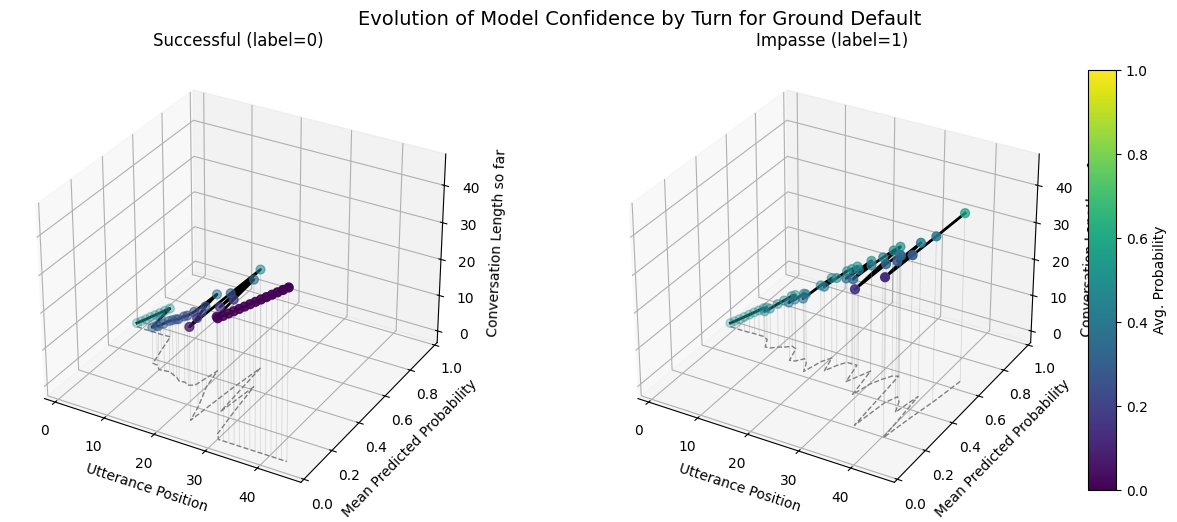

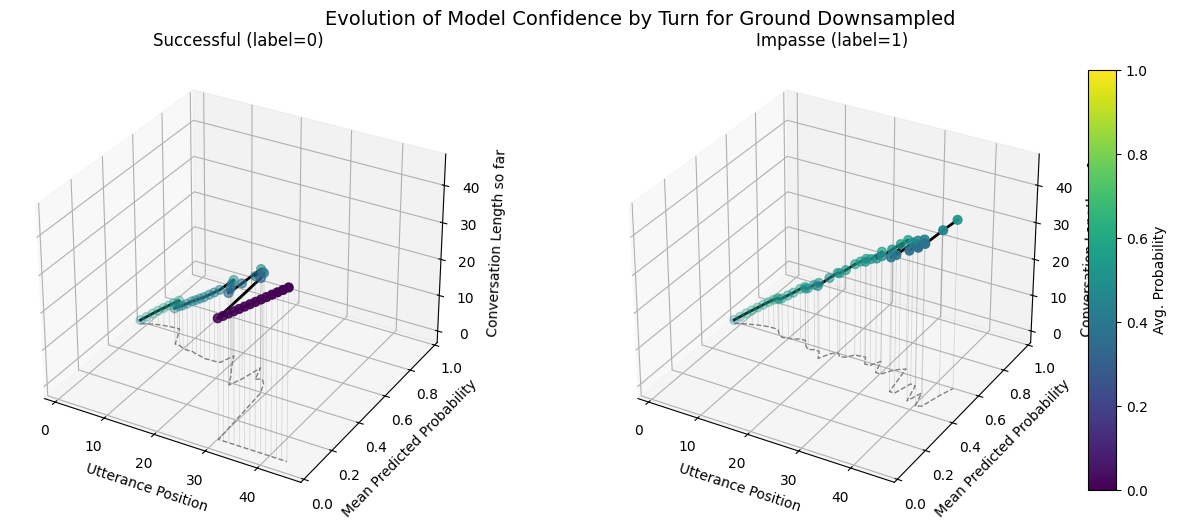

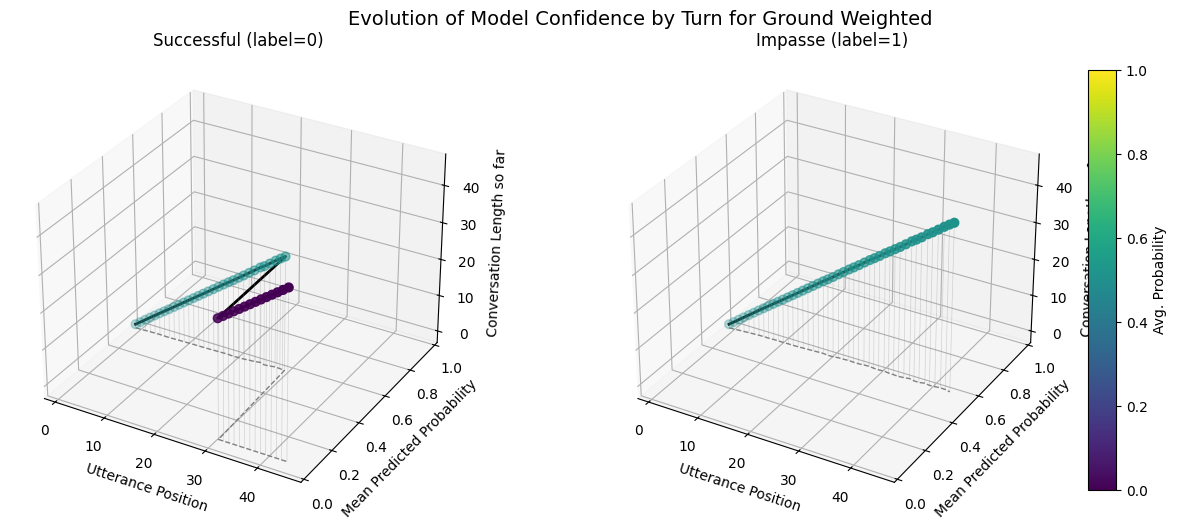

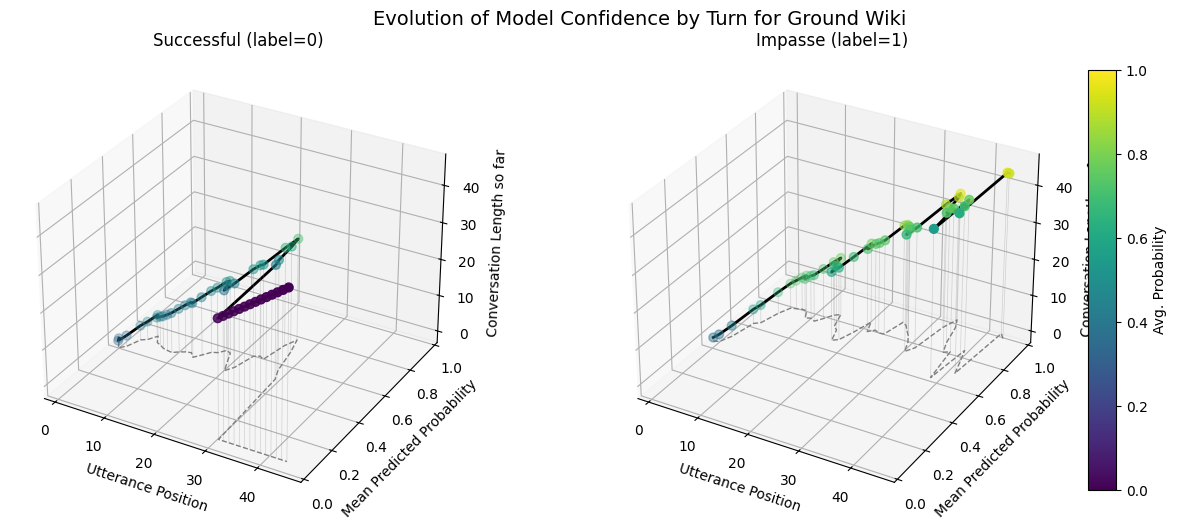

In [230]:
import numpy as np
plot_position_score_evolution_by_outcome(no_samp["ground_corpus"], name = "Ground Default")
plot_position_score_evolution_by_outcome(down["ground_corpus"], name = "Ground Downsampled")
plot_position_score_evolution_by_outcome(wt["ground_corpus"], name = "Ground Weighted")
plot_position_score_evolution_by_outcome(wiki["ground_corpus"], name = "Ground Wiki")

## No Last Utt Model Performance Comparison Across Default, Weighted, Downsampled Variants

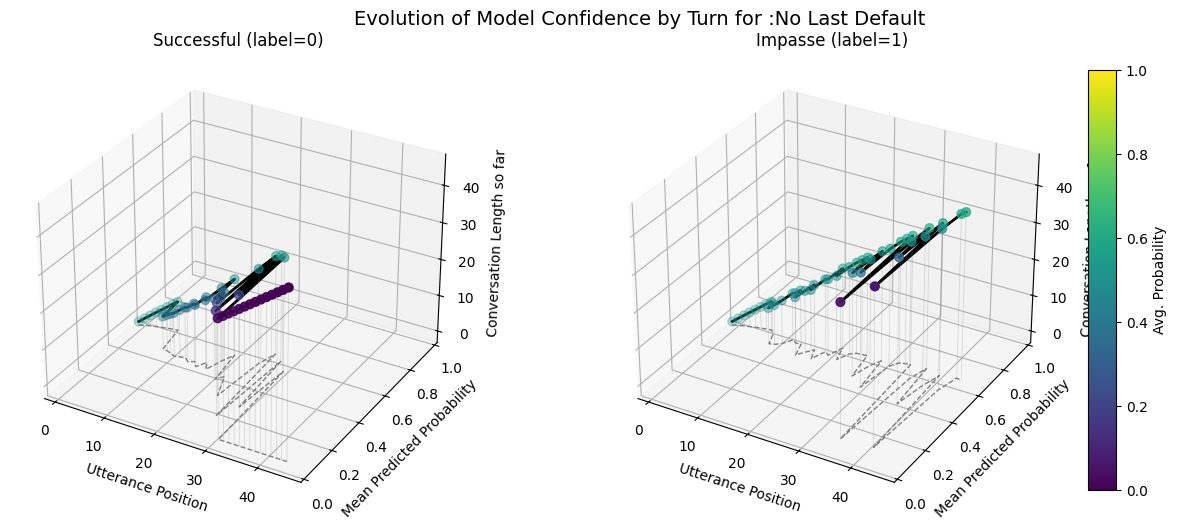

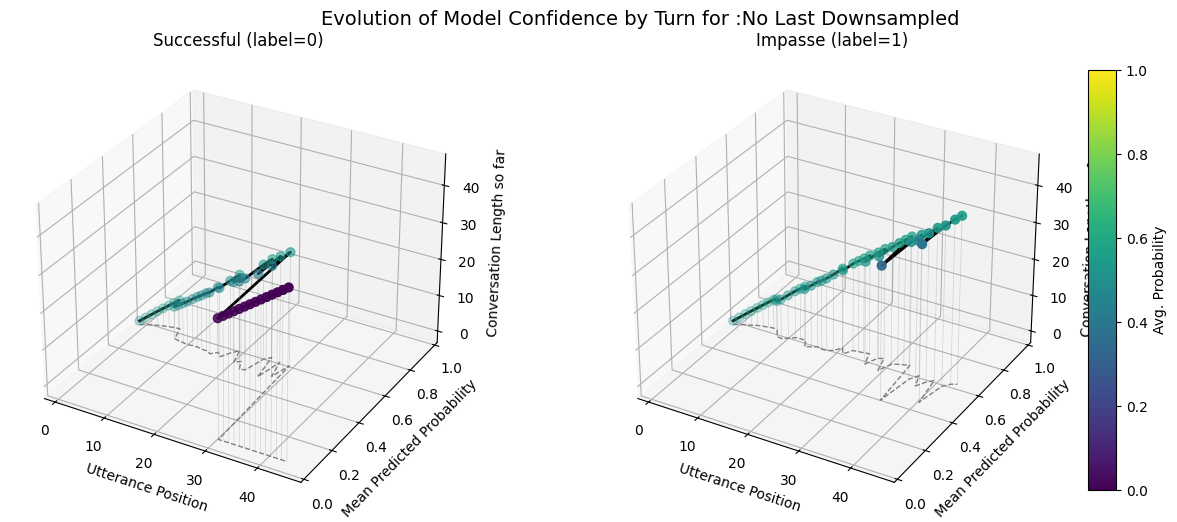

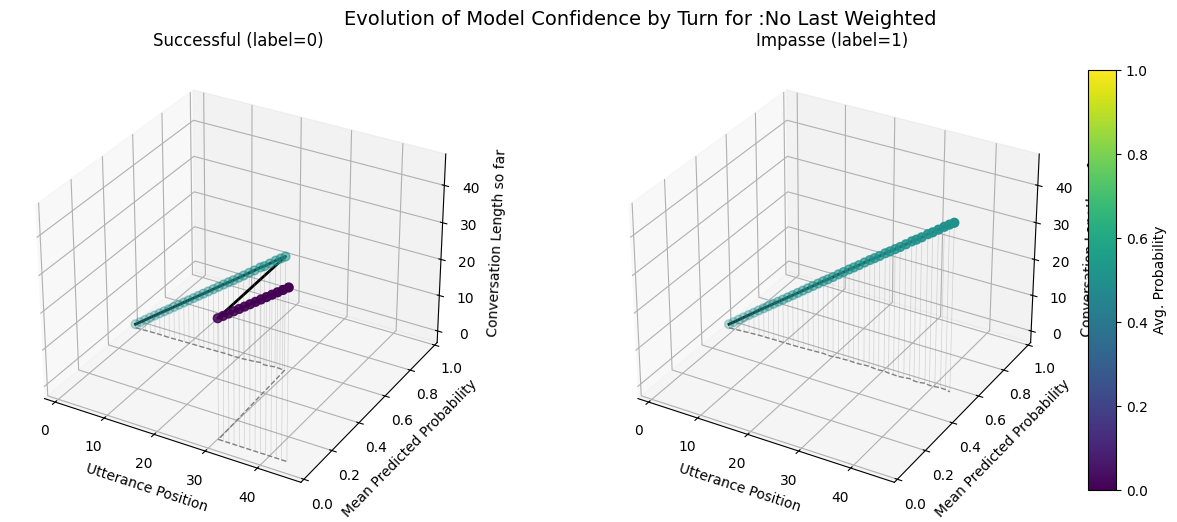

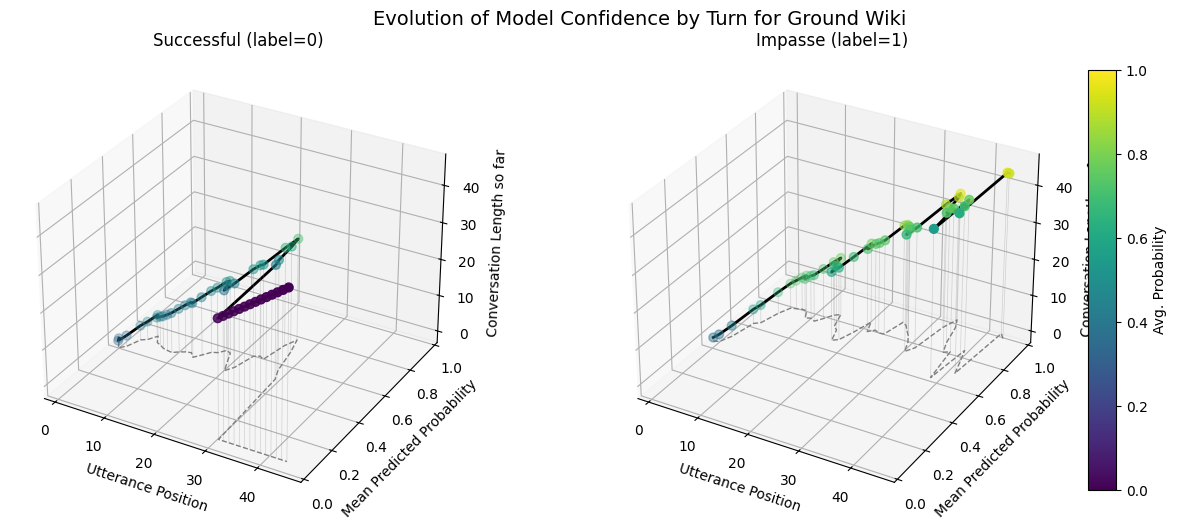

In [233]:
import numpy as np
plot_position_score_evolution_by_outcome(no_samp["no_last_corpus"], name = ":No Last Default")
plot_position_score_evolution_by_outcome(down["no_last_corpus"], name = ":No Last Downsampled")
plot_position_score_evolution_by_outcome(wt["no_last_corpus"], name = ":No Last Weighted")
plot_position_score_evolution_by_outcome(wiki["ground_corpus"], name = "Ground Wiki")

## No Last/No Submit Model Performance Comparison Across Default, Weighted, Downsampled Variants

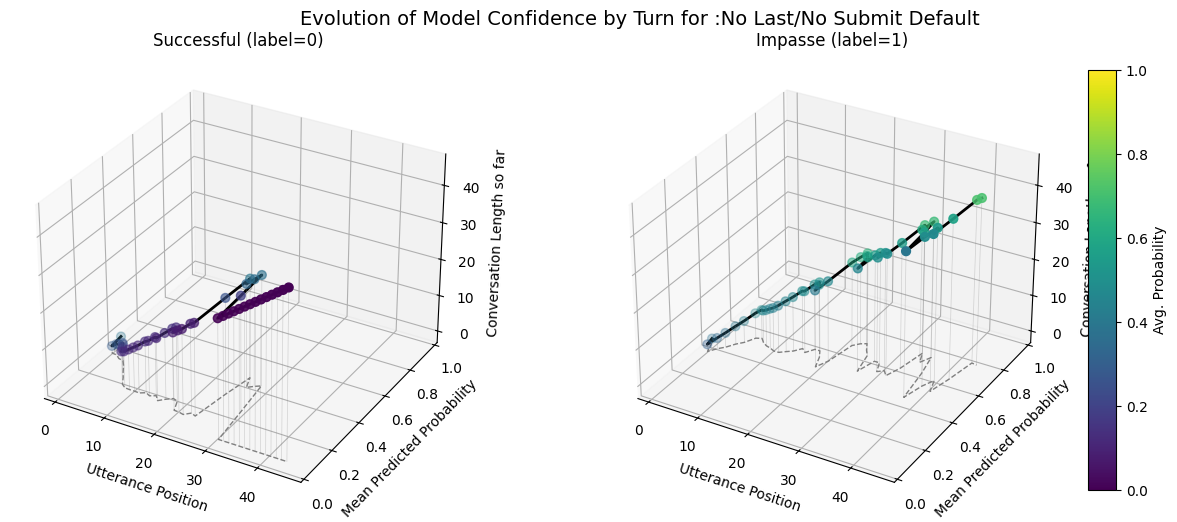

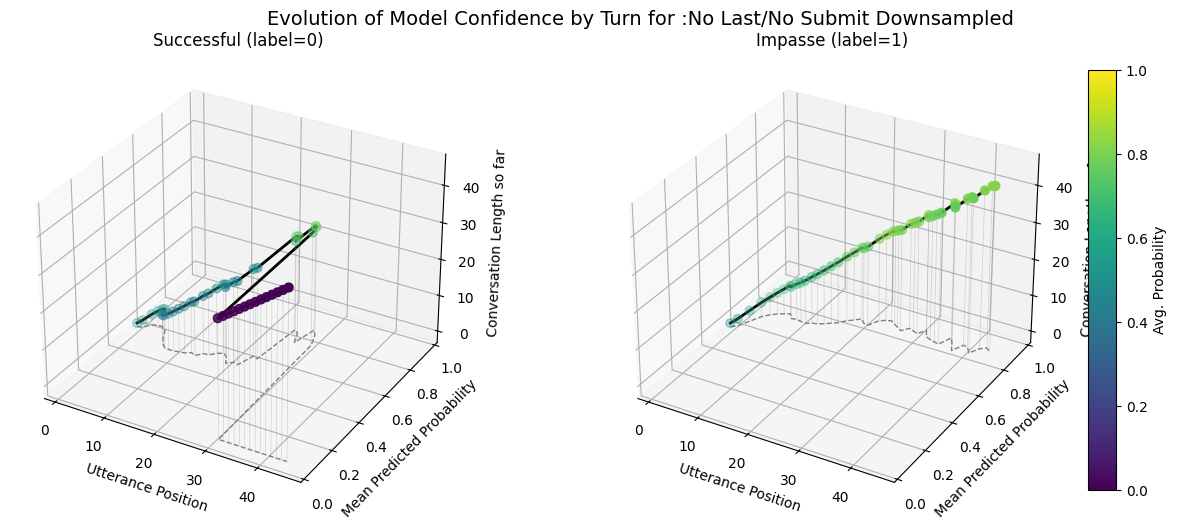

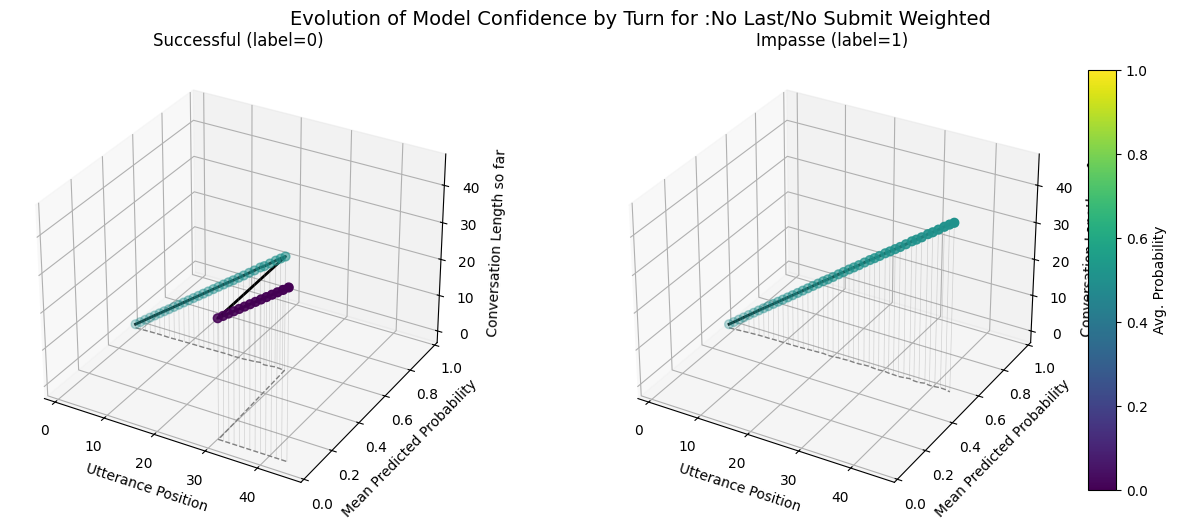

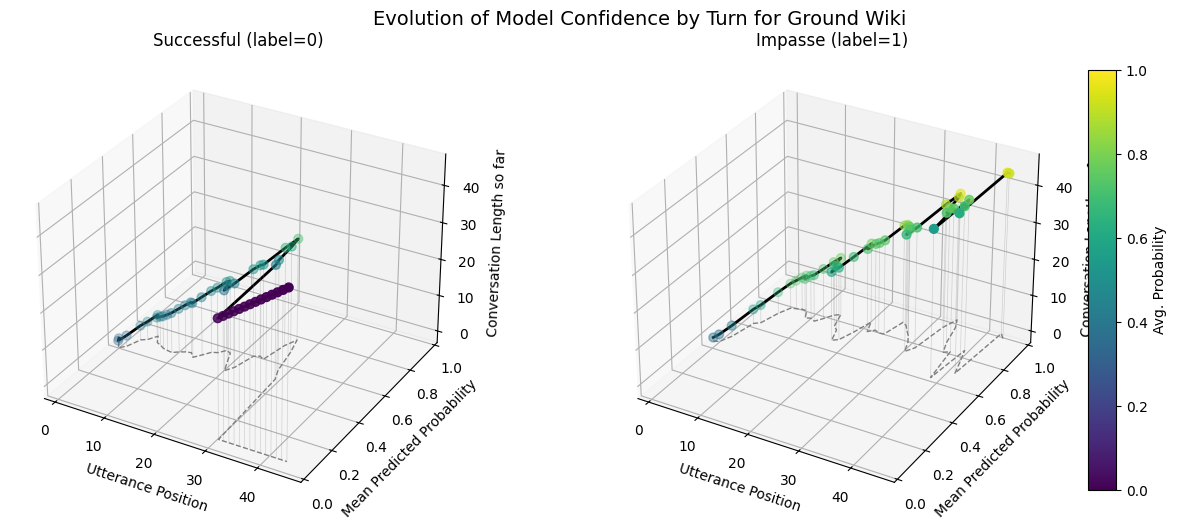

In [236]:
import numpy as np
plot_position_score_evolution_by_outcome(no_samp["no_subm_corpus"], name = ":No Last/No Submit Default")
plot_position_score_evolution_by_outcome(down["no_subm_corpus"], name = ":No Last/No Submit Downsampled")
plot_position_score_evolution_by_outcome(wt["no_subm_corpus"], name = ":No Last/No Submit Weighted")
plot_position_score_evolution_by_outcome(wiki["ground_corpus"], name = "Ground Wiki")

# Analysis with fine-tuned CRAFT

In [ ]:
model_wiki = CRAFTModel(
    initial_weights= "craft-wiki-finetuned",  # or "craft-wiki-finetuned"
    torch_device="cuda" if torch.cuda.is_available() else "cpu"
)



# Utility Functions

### Test Conversation Helpers

In [46]:
import pandas as pd

def getTestUtterancesandConvos(corpus):
    # 1. get utterances and conversations tables
    utt_df = corpus.get_utterances_dataframe()
    conv_df = corpus.get_conversations_dataframe()

    # 2. find all conversation IDs in the 'test' split
    test_convo_ids = conv_df[conv_df['meta.split'] == 'test'].index.tolist()
    # 3. filter utterances whose conversation_id is in that list
    test_utts = utt_df[utt_df['conversation_id'].isin(test_convo_ids)]
    return test_utts, test_convo_ids

def getSuccessLengths(utts):
    # 2. Filter to only those rows where meta.prediction == 1
    success_df = utts[utts['meta.prediction'] == 1]
    # 3) compute length (count of utterances) per conversation
    conversation_lengths = (
        utts
        .groupby('conversation_id')
        .size()
        .rename('length')
    )
    # 4) pick out only the conversations that appeared in pred1_df
    lengths_df = (
        conversation_lengths
        .loc[success_df['conversation_id'].unique()]
        .reset_index()           # makes 'conversation_id' a column again
    )
    return lengths_df

def getSuccessUtterances(utts):
    # 2. Filter to only those rows where meta.prediction == 1
    success_df = utts[utts['meta.prediction'] == 1]

ground_test_utt, ground_test_convos = getTestUtterancesandConvos(corpus_kodis_ground)
no_last_test_utt, no_last_test_convos = getTestUtterancesandConvos(corpus_kodis_no_last)
no_submit_last_test_utt, no_submit_last_test_convos = getTestUtterancesandConvos(corpus_kodis_no_submit_last)



def find_best_threshold(y_true, y_score):
    """
    Given true labels and predicted scores, compute the ROC curve
    and return the threshold that maximizes TPR − FPR (Youden's J).
    Returns:
      threshold: float      — the optimal cutoff
      tpr:       float      — true positive rate at that cutoff
      fpr:       float      — false positive rate at that cutoff
      youden:    float      — J = tpr − fpr
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    youden = tpr - fpr
    idx    = np.argmax(youden)
    return thresholds[idx], tpr[idx], fpr[idx], youden[idx]




### Save Helpers

In [49]:
from pathlib import Path
from datetime import datetime

def save_default():
    # root directory for all experiments
    results_root = Path('/work/data/fine_tuning_results/nosampling')

    # # make a new experiment folder, e.g. "run_20250506_153045"
    stamp   = datetime.now().strftime("run_%Y%m%d_%H%M%S")
    exp_dir = results_root / stamp
    exp_dir.mkdir(parents=True, exist_ok=False)

    # dump each corpus into its own subfolder under this run
    corpus_kodis_ground_orig.dump(
        name="corpus_kodis_ground_default",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )
    corpus_kodis_ground_nl.dump(
        name="corpus_kodis_no_last_default",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )
    corpus_kodis_no_ground_nls.dump(
        name="corpus_kodis_no_submit_last_default",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )

    # dump each corpus train
    corpus_kodis_ground.dump(
        name="corpus_kodis_ground_default_train",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )
    corpus_kodis_no_last.dump(
        name="corpus_kodis_no_last_default_train",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )
    corpus_kodis_no_submit_last.dump(
        name="corpus_kodis_no_last_submit_default_train",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )

    # save your dataframes
    ground_default_df.to_csv(exp_dir / "ground_conv_default_df.csv", index=False)
    no_last_default_df.to_csv(exp_dir / "no_last_conv_df_default.csv", index=False)
    no_last_submit_default_df.to_csv(exp_dir / "no_last_submit_conv_default_df.csv", index=False)

    # save your metrics.json into the same folder
    with open(exp_dir / 'ground_default_metrics.json', 'w') as f:
        json.dump(ground_default_metrics, f, indent=2)

    with open(exp_dir / 'no_last_default_metrics.json', 'w') as f:
        json.dump(no_last_default_metrics, f, indent=2)

    with open(exp_dir / 'no_last_submit_default_metrics.json', 'w') as f:
        json.dump(no_last_submit_default_metrics, f, indent=2)

    # “horizon” dictionaries
    with open(exp_dir / "ground_default_horizon.json", "w") as f:
        json.dump(ground_default_horizon, f, indent=2)
    with open(exp_dir / "no_last_default_horizon.json", "w") as f:
        json.dump(no_last_default_horizon, f, indent=2)
    with open(exp_dir / "no_last_submit_default_horizon.json", "w") as f:
        json.dump(no_last_submit_default_horizon, f, indent=2)

    # save your checkpoints
    checkpoint_ground_default       = model_ground_default._model
    checkpoint_no_last_default      = model_no_last_default._model
    checkpoint_no_submit_last_default = model_no_submit_last_default._model

    torch.save(checkpoint_ground_default,       exp_dir / "ground_default.pt")
    torch.save(checkpoint_no_last_default,      exp_dir / "no_last_default.pt")
    torch.save(checkpoint_no_submit_last_default, exp_dir / "no_last_submit_last_default.pt")
    print(f"Experiment saved to {exp_dir}")
    
def save_weighted():
    # root for all weighted‐loss experiments
    results_root_weighted = Path('/work/data/fine_tuning_results/nosampling_weighted')

    # make a new experiment folder, e.g. "run_20250506_154530"
    stamp = datetime.now().strftime("run_%Y%m%d_%H%M%S")
    exp_dir = results_root_weighted / stamp
    exp_dir.mkdir(parents=True, exist_ok=False)

    # dump each weighted‐loss corpus test
    corpus_kodis_ground.dump(
        name="corpus_kodis_ground_weighted_loss",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )
    corpus_kodis_ground_nl.dump(
        name="corpus_kodis_no_last_weighted_loss",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )
    corpus_kodis_ground_nls.dump(
        name="corpus_kodis_no_submit_weighted_loss",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )

    # dump each  corpus train
    corpus_kodis_ground.dump(
        name="corpus_kodis_ground_weighted_train",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )
    corpus_kodis_no_last.dump(
        name="corpus_kodis_no_last_weighted_train",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )
    corpus_kodis_no_submit_last.dump(
        name="corpus_kodis_no_last_submit_weighted_train",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )

    # write out the conversation‐length dataframes
    ground_weight_df.to_csv(exp_dir / "ground_weight_conv_df.csv", index=False)
    no_last_weight_df.to_csv(exp_dir / "nolast_weight_conv_df.csv", index=False)
    no_last_submit_weight_df.to_csv(exp_dir / "no_submit_last_weight_conv_df.csv", index=False)

    # write out the JSON metrics
    with open(exp_dir / 'ground_weighted_metrics.json', 'w') as f:
        json.dump(ground_weight_metrics, f, indent=2)
    with open(exp_dir / 'no_last_weighted_metrics.json', 'w') as f:
        json.dump(no_last_weight_metrics, f, indent=2)
    with open(exp_dir / 'no_last_submit_weighted_metrics.json', 'w') as f:
        json.dump(no_last_submit_weight_metrics, f, indent=2)

    with open(exp_dir / "ground_weight_horizon.json", "w") as f:
        json.dump(ground_weight_horizon, f, indent=2)
    with open(exp_dir / "no_last_weight_horizon.json", "w") as f:
        json.dump(no_last_weight_horizon, f, indent=2)
    with open(exp_dir / "no_last_submit_weight_horizon.json", "w") as f:
        json.dump(no_last_submit_weight_horizon, f, indent=2)

    # save your trained checkpoints
    checkpoint_ground_weighted        = model_ground_weighted._model
    checkpoint_no_last_weighted       = model_no_last_weighted._model
    checkpoint_no_submit_last_weighted = model_no_submit_last_weighted._model

    torch.save(checkpoint_ground_weighted,        exp_dir / "ground_weighted.pt")
    torch.save(checkpoint_no_last_weighted,       exp_dir / "no_last_weighted.pt")
    torch.save(checkpoint_no_submit_last_weighted, exp_dir / "no_submit_last_weighted.pt")
    print(f"Experiment saved to {exp_dir}")

def save_downsampled():
    # root for all downsampled experiments
    results_root_downsampled = Path('/work/data/fine_tuning_results/downsampled')

    # make a new experiment folder, e.g. "run_20250506_154530"
    stamp   = datetime.now().strftime("run_%Y%m%d_%H%M%S")
    exp_dir = results_root_downsampled / stamp
    exp_dir.mkdir(parents=True, exist_ok=False)

    # dump each downsampled corpus test
    corpus_kodis_ground_orig.dump(
        name="corpus_kodis_ground_downsampled",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )
    corpus_kodis_ground_nl.dump(
        name="corpus_kodis_no_last_downsampled",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )
    corpus_kodis_ground_nls.dump(
        name="corpus_kodis_no_last_submit_downsampled",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )

    # dump each corpus train
    corpus_kodis_ground.dump(
        name="corpus_kodis_ground_downsampled_train",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )
    corpus_kodis_no_last.dump(
        name="corpus_kodis_no_last_downsampled_train",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )
    corpus_kodis_no_submit_last.dump(
        name="corpus_kodis_no_last_submit_downsampled_train",
        base_path=exp_dir,
        overwrite_existing_corpus=False,
    )

    #write out the conversation‐length dataframes
    ground_downsampled_df.to_csv(exp_dir / "ground_downsampled_conv_df.csv", index=False)
    no_last_downsampled_df.to_csv(exp_dir / "nolast_downsampled_conv_df.csv", index=False)
    no_last_submit_downsampled_df.to_csv(exp_dir / "no_submit_last_downsampled_conv_df.csv", index=False)

    # write out the JSON metrics
    with open(exp_dir / 'ground_downsampled_metrics.json', 'w') as f:
        json.dump(ground_downsampled_metrics, f, indent=2)
    with open(exp_dir / 'no_last_downsampled_metrics.json', 'w') as f:
        json.dump(no_last_downsampled_metrics, f, indent=2)
    with open(exp_dir / 'no_last_submit_downsampled_metrics.json', 'w') as f:
        json.dump(no_last_submit_downsampled_metrics, f, indent=2)
    with open(exp_dir / 'model_config.json', 'w') as f:
        json.dump(DEFAULT_CONFIG_downsampled, f, indent=2)

    # Save the ground_horizon_utterances, no_last_horizon_utterances, and no_last_submit_horizon_utterances
    with open(exp_dir / "ground_horizon_utterances.json", "w") as f:
        json.dump(groun_horizon_downsampled, f, indent=2)
    with open(exp_dir / "no_last_horizon_utterances.json", "w") as f:
        json.dump(no_last_horizon_downsampled, f, indent=2)
    with open(exp_dir / "no_last_submit_horizon_utterances.json", "w") as f:
        json.dump(no_last_submit_horizon_downsampled, f, indent=2)

    # # save your trained checkpoints
    checkpoint_ground_downsampled        = model_ground_downsampled._model
    checkpoint_no_last_downsampled       = model_no_last_downsampled._model
    checkpoint_no_submit_last_downsampled = model_no_submit_last_downsampled._model

    torch.save(checkpoint_ground_downsampled,        exp_dir / "ground_downsampled.pt")
    torch.save(checkpoint_no_last_downsampled,       exp_dir / "no_last_downsampled.pt")
    torch.save(checkpoint_no_submit_last_downsampled,  exp_dir / "no_submit_last_downsampled.pt")
    print(f"Experiment saved to {exp_dir}")

### Conversation-Level Metrics Plotting Utility
- (Derailment probability aggregated into 1 score for each conversation from all predicted utterances -> assign forecast label)

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Callable
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay
)
from IPython.display import display
from sklearn.calibration import CalibrationDisplay
def find_best_threshold(y_true, y_score):
    """
    Return the threshold that maximizes Youden's J = TPR − FPR.
    """
    fpr, tpr, thresh = roc_curve(y_true, y_score)
    youden = tpr - fpr
    idx    = np.argmax(youden)
    return thresh[idx], tpr[idx], fpr[idx], youden[idx]


def apply_best_threshold(corpus, threshold,prob_key= "pred_score", best_pred_key= "best_prediction",
    best_label_key= "best_forecast", selector: Callable[[Conversation], bool] = lambda convo: True):
    for convo in corpus.iter_conversations(selector):
        any_pos = False
        for utt in convo.iter_utterances():
            score = utt.meta.get(prob_key, 0.0)
            pred  = int(score >= threshold)
            utt.meta[best_pred_key] = pred
            if pred:
                any_pos = True
        convo.meta[best_label_key] = int(any_pos)

def horizon(corpus: Corpus, selector: Callable[[Conversation], bool] = lambda convo: True):
        comments_until_end = {}
        for convo in corpus.iter_conversations(selector):
            if selector(convo) and convo.meta["best_forecast"] == 1:
                for i, utt in enumerate(convo.get_chronological_utterance_list()):
                    prediction = utt.meta["best_prediction"]
                    if prediction is not None and prediction > 0:
                        comments_until_end[convo.id] = (
                            len(convo.get_chronological_utterance_list()) - i
                        )
                        break
        return comments_until_end

"""Taken + modified from forecaster class"""
def summarize(corpus: Corpus, selector: Callable[[Conversation], bool] = lambda convo: True, threshold = None):
        df = corpus.get_conversations_dataframe(selector=selector)

         # counts
        tp = ((df["meta.label"]==1) & (df["meta.best_forecast"]==1)).sum()
        fp = ((df["meta.label"]==0) & (df["meta.best_forecast"]==1)).sum()
        tn = ((df["meta.label"]==0) & (df["meta.best_forecast"]==0)).sum()
        fn = ((df["meta.label"]==1) & (df["meta.best_forecast"]==0)).sum()

        # accuracy is always well‑defined
        acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0

        # precision, recall, fpr guard against zero‐denom
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr       = fp / (fp + tn) if (fp + tn) > 0 else 0.0

        # F1 = 2 * (precision * recall) / (precision + recall)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0


        return {
            "Accuracy":  acc,
            "Precision": precision,
            "Recall":    recall,
            "FPR":       fpr,
            "F1":        f1,
            "Threshold": threshold,}
       


def compare_craft_models(corpora_info, split_key="split", train_tag="train", test_tag="test", best= None):
    """
    corpora_info: list of (name, Corpus, metrics_dict, conv_df, horizon_dict)
    """
    names, corpora, metrics_list, dfs, horizons = zip(*corpora_info)

    # 1) avg lengths
    print("== Avg. Conversation Length ==")
    for name, corpus in zip(names, corpora):
        train_lens = [
            len(conv.get_utterance_ids())
            for conv in corpus.iter_conversations()
            if conv.meta.get(split_key)==train_tag
        ]
        test_lens  = [
            len(conv.get_utterance_ids())
            for conv in corpus.iter_conversations()
            if conv.meta.get(split_key)==test_tag
        ]
        print(f"  {name:20s}  train={np.mean(train_lens):.1f}  test={np.mean(test_lens):.1f}")
    print()

    # 2) metrics table
    print("== Conversation‑level Test Metrics ==")
    metrics_df = pd.DataFrame(metrics_list, index=names)
    display(metrics_df)

    # 3) horizon histograms
    all_vals   = np.concatenate([list(h.values()) for h in horizons])
    global_max = int(all_vals.max()) if all_vals.size else 1
    bins       = np.arange(1, global_max+2)
    fig, axes  = plt.subplots(1, len(names), figsize=(5*len(names),4), sharey=True)
    if len(names)==1: axes=[axes]
    for ax, name, hor in zip(axes, names, horizons):
        vals = np.array(list(hor.values()))
        ax.hist(vals, bins=bins, density=True, edgecolor="k")
        ax.set_title(f"{name}\nForecast Horizon")
        ax.set_xlabel("# comments after first+forecast")
        ax.set_xlim(1, global_max+1)
        if ax is axes[0]:
            ax.set_ylabel("Percent of convos")
        ax.text(.05,.85, f"μ={vals.mean():.1f}\nmed={np.median(vals):.1f}",
                transform=ax.transAxes, va="top", fontsize=9)
    plt.tight_layout()
    plt.show()

    # 4) merge conversation‑level dfs
    merged = dfs[0][['label','score','forecast']].rename(
        columns={'score':f'score_{names[0]}','forecast':f'forecast_{names[0]}'})
    for name, df in zip(names[1:], dfs[1:]):
        merged = merged.join(
            df[['score','forecast']].rename(
                columns={'score':f'score_{name}','forecast':f'forecast_{name}'}
            ), how='inner'
        )

    # 5) calibration + probability histogram
    fig, (ax_cal, ax_hist) = plt.subplots(1,2, figsize=(12,4))
    for name in names:
        CalibrationDisplay.from_predictions(
            y_true=merged['label'],
            y_prob=merged[f'score_{name}'],
            n_bins=10, name=name, ax=ax_cal
        )
    ax_cal.set_title("Calibration Curves"); ax_cal.grid(True)

    bins_prob = np.linspace(0,1,11)
    for name in names:
        ax_hist.hist(merged[f'score_{name}'], bins=bins_prob,
                     alpha=0.6, label=name, edgecolor='k')
    ax_hist.set_title("Probability Histogram")
    ax_hist.set_xlabel("Predicted probability")
    ax_hist.set_ylabel("Count of convos")
    ax_hist.legend(); ax_hist.grid(True)

    plt.tight_layout(); plt.show()

    # 6) confusion matrices
    fig, axes = plt.subplots(1, len(names), figsize=(4*len(names),4))
    if len(names)==1: axes=[axes]
    for ax, name in zip(axes, names):
        ConfusionMatrixDisplay.from_predictions(
            y_true=merged['label'],
            y_pred=merged[f'forecast_{name}'],
            display_labels=["Success","Impasse"],
            ax=ax
        )
        ax.set_title(name)
    plt.tight_layout(); plt.show()

    # 7) ROC & PR curves + find best thresholds
    thresholds = {}
    metrics = {}
    corpora = {}
    plt.figure(figsize=(12,5))
    # ROC
    plt.subplot(1,2,1)
    for name in names:
        y_true = merged['label']
        y_score= merged[f'score_{name}']
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
        thr, t, f, j = find_best_threshold(y_true, y_score)
        thresholds[name] = thr
        print(f"{name:20s} best thr={thr:.3f}, TPR={t:.3f}, FPR={f:.3f}, J={j:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.title("ROC Curves"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(True)

    #annotate corpora with best prediction:
    for name, corpus, *_ in corpora_info:
        if name not in thresholds:
            raise KeyError(f"No threshold provided for model {name!r}")
        apply_best_threshold(corpus, thresholds[name],  selector =lambda convo: convo.meta.get("split") == "test")
        # create best metrics
        metrics[name] = summarize(corpus, selector =lambda convo: convo.meta.get("split") == "test", threshold=thresholds[name])
        corpora[name] = corpus


    # PR
    plt.subplot(1,2,2)
    for name in names:
        prec, rec, _ = precision_recall_curve(merged['label'], merged[f'score_{name}'])
        ap = average_precision_score(merged['label'], merged[f'score_{name}'])
        plt.plot(rec, prec, label=f"{name} (AP={ap:.2f})")
    plt.title("Precision–Recall Curves"); plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

    # 8) summary table
    summary = {
        f"{name}_acc":      (merged['label']==merged[f'forecast_{name}']).mean()
        for name in names
    }
    summary.update({
        f"{name}_avg_prob": merged[f'score_{name}'].mean()
        for name in names
    })
    print("== Summary of Convo Acc & Avg Prob ==")
    display(pd.DataFrame(summary, index=["conversation_level"]))

    return thresholds, metrics, corpora



def compare_best_models(thresholds, metrics, corpora, split_key = "split", test_tag = "test"):
    names = list(corpora.keys())
    # 1) metrics table
    print("== Conversation‑level Best Threshold Test Set Metrics ==")
    metrics_df = pd.DataFrame(metrics, index=list(metrics.values())[0].keys()).T
    display(metrics_df)

    # 2) confusion matrices
    fig, axes = plt.subplots(1, len(names), figsize=(4*len(names), 4))
    if len(names)==1: axes=[axes]

    for ax, name in zip(axes, names):
        
        # collect true/test only
        conv_df = corpora[name].get_conversations_dataframe().reset_index()
        test_df = conv_df[conv_df[f"meta.{split_key}"] == test_tag]
        y_true = test_df["meta.label"].astype(int)
        y_pred = test_df["meta.best_forecast"].astype(int)
        ConfusionMatrixDisplay.from_predictions(
            y_true=y_true,
            y_pred=y_pred,
            display_labels=["Impasse","Success"],
            cmap="Blues",
            ax=ax
        )
        ax.set_title(name)
    plt.tight_layout()
    plt.show()

    # 3) forecast‑horizon histograms
    fig, axes = plt.subplots(1, len(names), figsize=(5*len(names), 4), sharey=True)
    if len(names)==1: axes=[axes]

    # compute global max horizon to align bins
    all_horizons = []
    for name in names:
        h = horizon(corpora[name], selector=lambda c: c.meta.get(split_key)==test_tag)
        all_horizons.extend(h.values())
    max_h = int(max(all_horizons)) if all_horizons else 1
    bins = np.arange(1, max_h+2)

    for ax, name in zip(axes, names):
        h = horizon(corpora[name], selector=lambda c: c.meta.get(split_key)==test_tag)
        vals = np.array(list(h.values()))
        ax.hist(vals, bins=bins, density=True, edgecolor="k")
        ax.set_title(f"{name}\nForecast Horizon")
        ax.set_xlabel("# utts after first + forecast")
        ax.set_xlim(1, max_h+1)
        if ax is axes[0]:
            ax.set_ylabel("Percent of convos")
        m, md = vals.mean() if vals.size else 0, np.median(vals) if vals.size else 0
        ax.text(.05, .85, f"μ={m:.1f}\nmed={md:.1f}",
                transform=ax.transAxes, va="top", fontsize=9)
    plt.tight_layout()
    plt.show()

### Forecast Probability Trends

In [212]:
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict


def plot_position_score_evolution_by_outcome(
    corpus, split_key="split", test_tag="test",
    prob_key="pred_score", name=None
):
    pos_scores = {0: defaultdict(list), 1: defaultdict(list)}
    for convo in corpus.iter_conversations():
        if convo.meta.get(split_key) != test_tag:
            continue
        lbl = convo.meta.get("label")
        for p, utt in enumerate(convo.iter_utterances(), start=1):
            score = utt.meta.get(prob_key)
            if score is not None:
                pos_scores[lbl][p].append(score)

    overall_max_pos = max(
        max(d.keys()) for d in pos_scores.values() if d
    ) if any(pos_scores.values()) else 0

    fig = plt.figure(figsize=(14, 6))
    fig.subplots_adjust(left=0.05, right=0.80, wspace=0.3)

    for ix, lbl in enumerate((0, 1), start=1):
        ax = fig.add_subplot(1, 2, ix, projection='3d')

        X = np.arange(1, overall_max_pos + 1)
        Y = [
            np.mean(pos_scores[lbl].get(p, [])) if pos_scores[lbl].get(p)
            else 0.0
            for p in X
        ]
        Z = X

        # force colormap and scatter scale to 0→1
        sc = ax.scatter(
            X, Y, Z,
            c=Y, cmap='viridis',
            vmin=0, vmax=1,
            s=40
        )
        ax.plot(X, Y, Z, color='black', lw=2)
        ax.plot(X, Y, zs=0, zdir='z', color='gray', ls='--', lw=1)
        for xi, yi, zi in zip(X, Y, Z):
            ax.plot([xi, xi], [yi, yi], [0, zi],
                    color='gray', alpha=0.3, lw=0.5)

        ax.set_xlabel("Utterance Position")
        ax.set_ylabel("Mean Predicted Probability")
        ax.set_zlabel("Conversation Length so far")
        ax.set_ylim(0, 1)                      # <— lock the probability axis
        title_lbl = "Successful" if lbl == 0 else "Impasse"
        ax.set_title(f"{title_lbl} (label={lbl})")

    # add colorbar to its own axes on the far right
    cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
    cb = fig.colorbar(sc, cax=cbar_ax)
    cb.set_label("Avg. Probability")

    if name:
        fig.suptitle(
            f"Evolution of Model Confidence by Turn for {name}",
            y=0.95, fontsize=14
        )

    plt.show()




def get_test_utterances_df(corpus, split_key="split", test_tag="test"):
    utts = corpus.get_utterances_dataframe()  # contains columns like ['id','conversation_id','text',…]

    convs = corpus.get_conversations_dataframe()  # index is conversation_id, has 'meta.split'
    convs = convs.reset_index().rename(
        columns={ "id": "conversation_id", f"meta.{split_key}": "split" }
    )[[ "conversation_id", "split" ]]
    
    merged = pd.merge(
        utts,
        convs,
        on="conversation_id",
        how="left"
    )
    test_utts = merged[ merged["split"] == test_tag ].drop(columns=["split"])
    return test_utts



### Load Data

In [58]:
downsampled_res  = Path('/work/data/fine_tuning_results/downsampled/run_20250509_102130')
nosampling_res   = Path('/work/data/fine_tuning_results/nosampling/run_20250509_090059')
weighted_res     = Path('/work/data/fine_tuning_results/nosampling_weighted/run_20250509_015048')
#/work/data/fine_tuning_results/nosampling/run_20250509_090059/corpus_kodis_ground_default
def load_artifact(exp_dir: Path, name: str):
    p = exp_dir / name
    if (p.with_suffix('.json')).exists():
        return json.loads((p.with_suffix('.json')).read_text())
    if (p.with_suffix('.csv')).exists():
        return pd.read_csv(p.with_suffix('.csv'))
    if p.is_dir():
        return Corpus(filename= str(p))
    if (p.with_suffix('.pt')).exists():
        return torch.load(p.with_suffix('.pt'))
    raise FileNotFoundError(f"No artifact {name} in {exp_dir}")

def load_all_variants(exp_dir: Path):
    # detect which naming scheme this folder uses
    if (exp_dir / "corpus_kodis_ground_downsampled").is_dir():
        variant = "downsampled"
    elif (exp_dir / "corpus_kodis_ground_weighted_loss").is_dir():
        variant = "weighted"
    else:
        variant = "default"

    # build name‐templates
    tpl = {
        "downsampled": {
            "ground_corpus":   "corpus_kodis_ground_downsampled",
            "ground_df":       "ground_downsampled_conv_df",
            "ground_metrics":  "ground_downsampled_metrics",
            "ground_horizon":  "ground_horizon_utterances",
            # "ground_chkpt":    "ground_downsampled",

            "no_last_corpus":  "corpus_kodis_no_last_downsampled",
            "no_last_df":      "nolast_downsampled_conv_df",
            "no_last_metrics": "no_last_downsampled_metrics",
            "no_last_horizon": "no_last_horizon_utterances",
            # "no_last_chkpt":   "no_last_downsampled",

            "no_subm_corpus":  "corpus_kodis_no_last_submit_downsampled",
            "no_subm_df":      "no_submit_last_downsampled_conv_df",
            "no_subm_metrics": "no_last_submit_downsampled_metrics",
            "no_subm_horizon": "no_last_submit_horizon_utterances",
            # "no_subm_chkpt":   "no_submit_last_downsampled",
        },
        "weighted": {
            "ground_corpus":   "corpus_kodis_ground_weighted_loss",
            "ground_df":       "ground_weight_conv_df",
            "ground_metrics":  "ground_weighted_metrics",
            "ground_horizon":  "ground_weight_horizon",
            # "ground_chkpt":    "ground_weighted",

            "no_last_corpus":  "corpus_kodis_no_last_weighted_loss",
            "no_last_df":      "nolast_weight_conv_df",
            "no_last_metrics": "no_last_weighted_metrics",
            "no_last_horizon": "no_last_weight_horizon",
            # "no_last_chkpt":   "no_last_weighted",

            "no_subm_corpus":  "corpus_kodis_no_submit_weighted_loss",
            "no_subm_df":      "no_submit_last_weight_conv_df",
            "no_subm_metrics": "no_last_submit_weighted_metrics",
            "no_subm_horizon": "no_last_submit_weight_horizon",
            # "no_subm_chkpt":   "no_submit_last_weighted",
        },
        "default": {
            "ground_corpus":   "corpus_kodis_ground_default",
            "ground_df":       "ground_conv_default_df",
            "ground_metrics":  "ground_default_metrics",
            "ground_horizon":  "ground_default_horizon",
            # "ground_chkpt":    "ground_default",

            "no_last_corpus":  "corpus_kodis_no_last_default",
            "no_last_df":      "no_last_conv_df_default",
            "no_last_metrics": "no_last_default_metrics",
            "no_last_horizon": "no_last_default_horizon",
            # "no_last_chkpt":   "no_last_default",

            "no_subm_corpus":  "corpus_kodis_no_submit_last_default",
            "no_subm_df":      "no_last_submit_conv_default_df",
            "no_subm_metrics": "no_last_submit_default_metrics",
            "no_subm_horizon": "no_last_submit_default_horizon",
            # "no_subm_chkpt":   "no_last_submit_last_default",
        },
    }[variant]

    return {
        key: load_artifact(exp_dir, fname)
        for key, fname in tpl.items()
    }


# Now load each regime:
down = load_all_variants(downsampled_res)
no_samp = load_all_variants(nosampling_res)
wt = load_all_variants(weighted_res)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3310cee6-b01b-482a-ad87-e3d6d3c746dc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>